#Proyecto - Modelando la pandemia
**El objetivo del proyecto es realizar un análisis sobre la pandemia y las distintas estrategias de respuesta frente al COVID-19**

Se utilizará un dataset de OurWorldInData, Coronavirus Pandemic (COVID-19) – the data, que contiene datos generales de varios países con respecto a la pandemia con el fin de poder realizar estudios.

##Recursos
**Carga de librerías necesarias y dataset**

In [ ]:
import math
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from scipy.optimize import curve_fit
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import loguniform
from sklearn.metrics import confusion_matrix

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/datos_acamica"

Mounted at /content/gdrive


In [ ]:
datos=pd.read_csv('/content/gdrive/My Drive/datos_acamica/2.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131705,ZWE,Africa,Zimbabwe,2021-11-03,133091.0,44.0,40.429,4684.0,1.0,1.286,8818.546,2.915,2.679,310.360,0.066,0.085,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5959034.0,3340933.0,2618101.0,NaN,16772.0,14098.0,39.48,22.14,17.35,NaN,934.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
131706,ZWE,Africa,Zimbabwe,2021-11-04,133112.0,21.0,33.143,4685.0,1.0,1.429,8819.937,1.391,2.196,310.426,0.066,0.095,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5975760.0,3350163.0,2625597.0,NaN,16726.0,14455.0,39.60,22.20,17.40,NaN,958.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
131707,ZWE,Africa,Zimbabwe,2021-11-05,133112.0,0.0,26.571,4685.0,0.0,

##Preprocesamiento

###Limpieza de datos
Análisis sobre qué información resultaría útil para el proyecto y a su vez que esté en condiciones de usarse.

**Cambio de formato para que fecha pueda ser interpretada como tal**

In [ ]:
datos["date"] = pd.to_datetime(datos["date"])

**Análisis de columnas con demasiados datos faltantes**

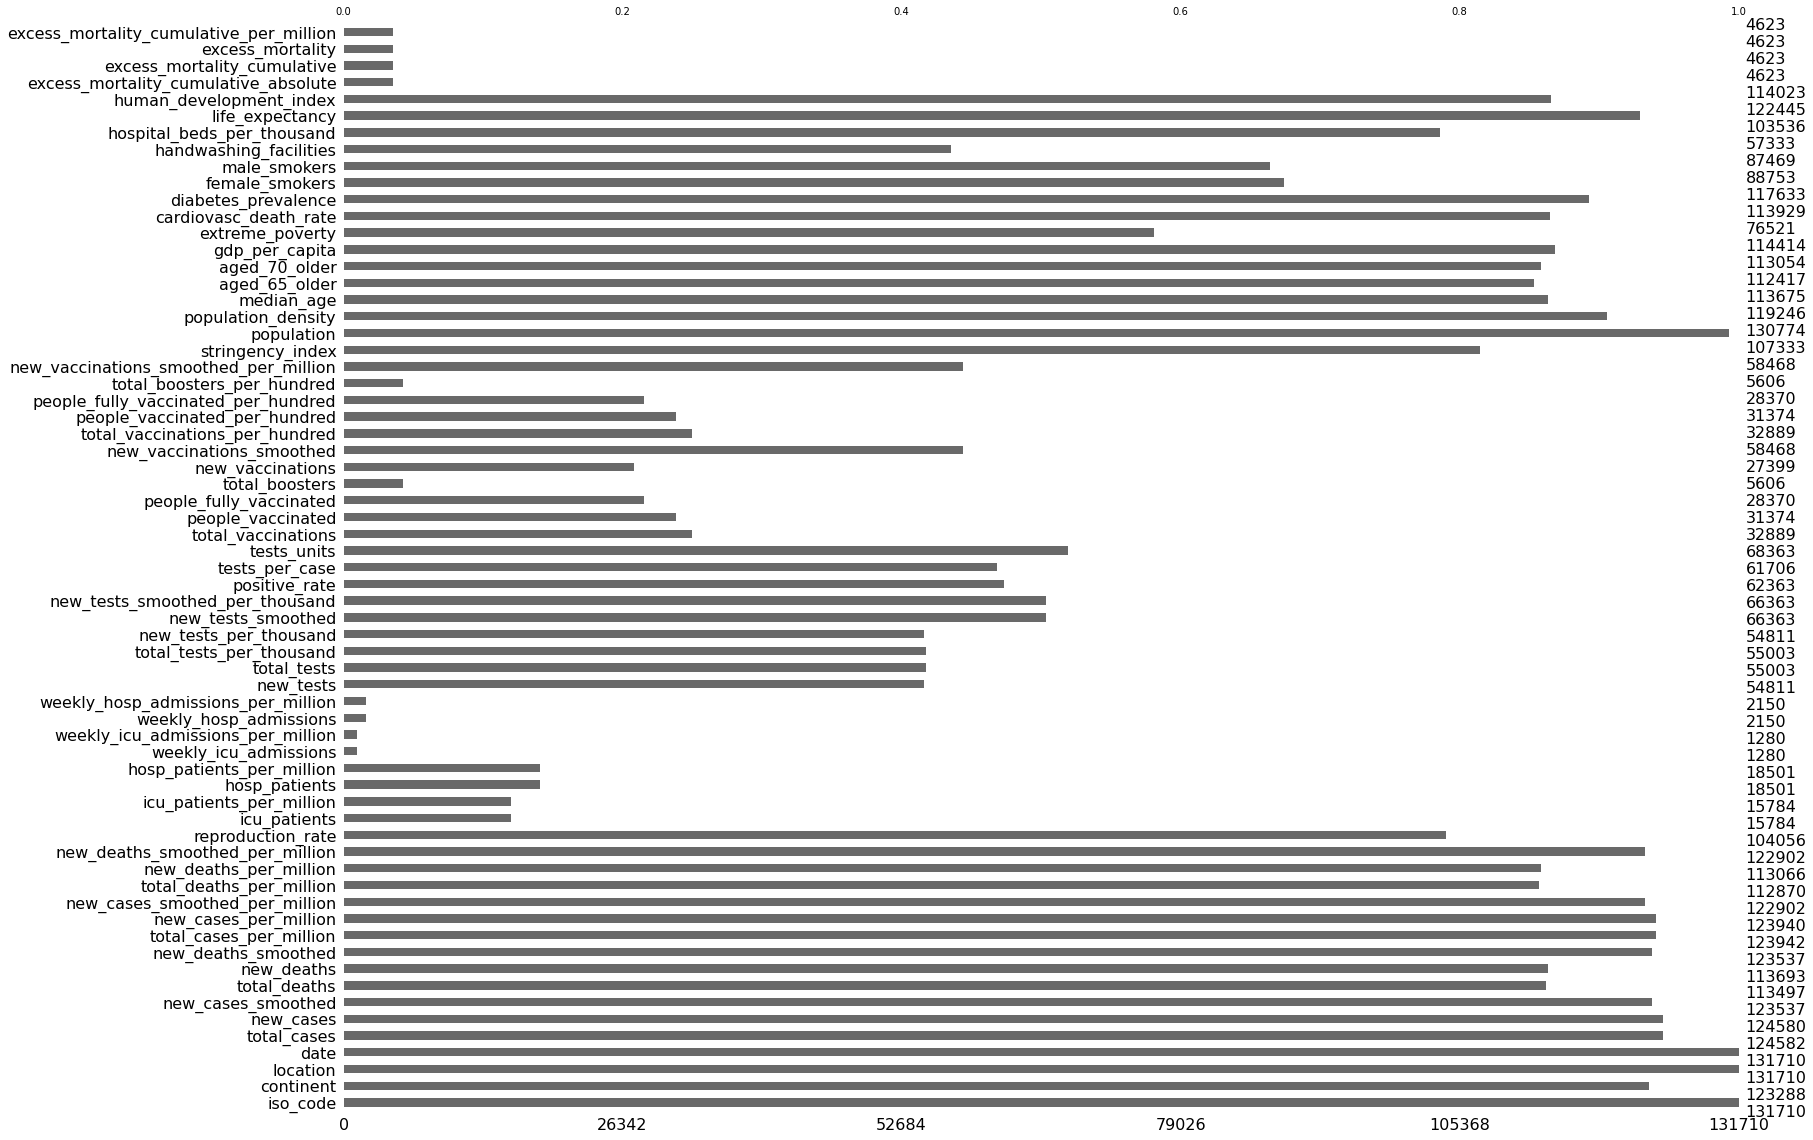

In [ ]:
#@title
msno.bar(datos)

*Gráfico de datos faltantes de las distintas columnas: Eliminamos los features que no brinden suficiente información para poder ser completados por distintos medios.*

In [ ]:
#@title
datos_covid = datos.drop(columns=["iso_code","continent","life_expectancy","new_cases_smoothed","total_vaccinations","total_tests","tests_units","new_deaths_smoothed","aged_65_older","extreme_poverty","aged_70_older","people_vaccinated","median_age","new_cases_smoothed_per_million","weekly_icu_admissions","new_deaths_smoothed_per_million","positive_rate","tests_per_case","icu_patients_per_million","hosp_patients_per_million","weekly_icu_admissions_per_million","weekly_hosp_admissions_per_million","total_tests_per_thousand","new_tests_per_thousand","new_tests_smoothed","new_tests_smoothed_per_thousand","new_vaccinations_smoothed","total_vaccinations_per_hundred","people_vaccinated_per_hundred","people_fully_vaccinated_per_hundred","total_boosters_per_hundred","new_vaccinations_smoothed_per_million","human_development_index","excess_mortality_cumulative_absolute","excess_mortality_cumulative_absolute","excess_mortality_cumulative_per_million","female_smokers","male_smokers","excess_mortality_cumulative","excess_mortality","hospital_beds_per_thousand","handwashing_facilities","diabetes_prevalence","cardiovasc_death_rate","population_density","weekly_hosp_admissions","weekly_hosp_admissions","icu_patients","hosp_patients","new_tests","total_boosters","people_fully_vaccinated","new_vaccinations"])

In [ ]:
#@title
datos_covid

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,0.126,0.126,NaN,NaN,NaN,8.33,39835428.0,1803.987
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,0.126,0.000,NaN,NaN,NaN,8.33,39835428.0,1803.987
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,0.126,0.000,NaN,NaN,NaN,8.33,39835428.0,1803.987
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,0.126,0.000,NaN,NaN,NaN,8.33,39835428.0,1803.987
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,0.126,0.000,NaN,NaN,NaN,8.33,39835428.0,1803.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131705,Zimbabwe,2021-11-03,133091.0,44.0,4684.0,1.0,8818.546,2.915,310.360,0.066,0.63,NaN,15092171.0,1899.775
131706,Zimbabwe,2021-11-04,133112.0,21.0,4685.0,1.0,8819.937,1.391,310.426,0.066,0.62,NaN,15092171.0,1899.775
131707,Zimbabwe,2021-11-05,133112.0,0.0,4685.0,0.0,8819.937,0.000,310.426,0.000,0.61,NaN,15092171.0,1899.775
131708,Zimbabwe,2021-11-06,133168.0,56.0,4685.0,0.0,8823.648,3.711,310.426,0.000,NaN,NaN,15092171.0,1899.775


**El proyecto sólo va a necesitar ocho países**

Estos países fueron elegidos ya que presentaron buenos resultados frente a la pandemia por igual y también poseen distintas estrategias, una de ellas la que se va a analizar, el uso de barbijos obligatorio en un período.

In [ ]:
#@title
datos_covid_8paises = datos_covid[datos_covid['location'].isin(["Finland", "Canada","United States","Sweden","France","Norway","United Kingdom","Spain"]) ].copy()

In [ ]:
#@title
datos_covid_8paises["location"].unique()

array(['Canada', 'Finland', 'France', 'Norway', 'Spain', 'Sweden',
       'United Kingdom', 'United States'], dtype=object)

**Reinicio el index para analizar correctamente**

In [ ]:
#@title
datos_covid_8paises = datos_covid_8paises.reset_index().copy()

In [ ]:
#@title
datos_covid_8paises = datos_covid_8paises.drop(["index"],axis = 1)

In [ ]:
#@title
datos_covid_8paises

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita
0,Canada,2020-01-26,1.0,1.0,NaN,NaN,0.026,0.026,NaN,NaN,NaN,2.78,38067913.0,44017.591
1,Canada,2020-01-27,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
2,Canada,2020-01-28,2.0,1.0,NaN,NaN,0.053,0.026,NaN,NaN,NaN,2.78,38067913.0,44017.591
3,Canada,2020-01-29,2.0,0.0,NaN,NaN,0.053,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
4,Canada,2020-01-30,2.0,0.0,NaN,NaN,0.053,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,United States,2021-11-03,46257736.0,84369.0,750424.0,1906.0,138947.556,253.425,2254.100,5.725,0.99,56.02,332915074.0,54225.446
5167,United States,2021-11-04,46339302.0,81566.0,751555.0,1131.0,139192.562,245.005,2257.498,3.397,1.00,56.02,332915074.0,54225.446
5168,United States,2021-11-05,46435967.0,96665.0,753926.0,2371.0,139482.921,290.359,2264.620,7.122,1.00,56.02,332915074.0,54225.446
5169,United States,2021-11-06,46465823.0,29856.0,754310.0,384.0,139572.602,89.681,2265.773,1.153,NaN,NaN,332915074.0,54225.446


###Outliers
Analizamos los valores atípicos para luego filtrarlos o imputarlos. Esto se realizará debido a que pueden ingresar datos incorrectamente y  afectaría el análisis.

In [ ]:
#@title
datos_covid_8paises_outliers=datos_covid_8paises.copy()

In [ ]:
#@title
nom_col_out = ["total_deaths","total_cases","location","new_cases","new_deaths","reproduction_rate","stringency_index"]

<Figure size 432x288 with 0 Axes>

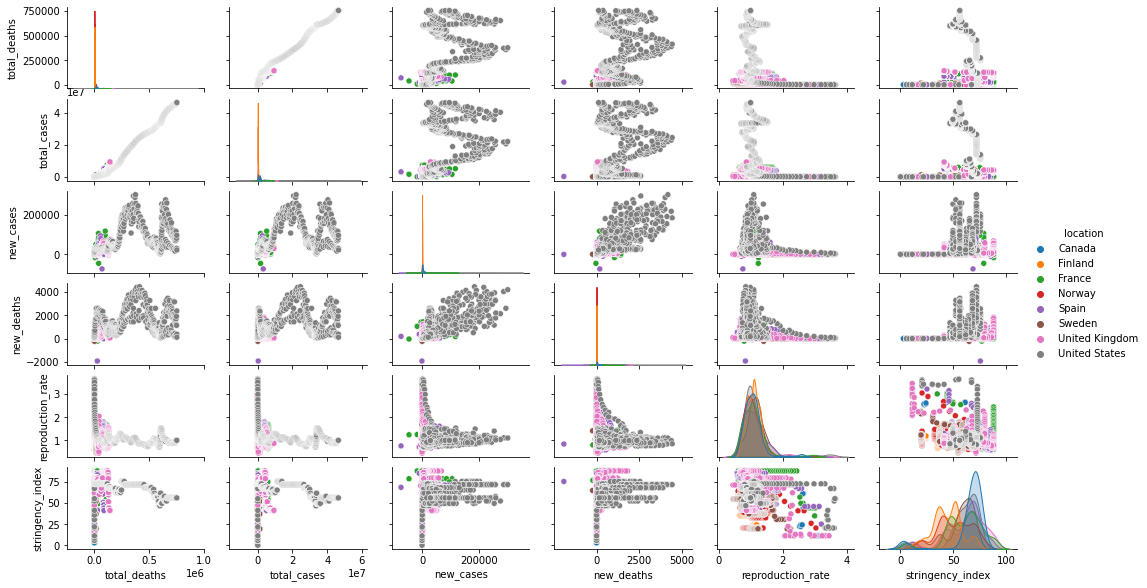

In [ ]:
#@title
plt.rcParams.update({'font.size': 10})
figu= plt.figure()

graph=sns.pairplot(datos_covid_8paises_outliers[nom_col_out],hue="location")
graph.fig.set_size_inches(16,8)
plt.grid()
plt.show()

*Gráfico de los distintos features en relación a los países: Esto nos permite un entendimiento más visual sobre los posibles outliers que se pueden tener, en este caso Estados Unidos con su situación particular de densidad de transporte público y su condición de gran población pudo haber llevado a que el número total de casos y de muertes sea muy alta en comparación.*

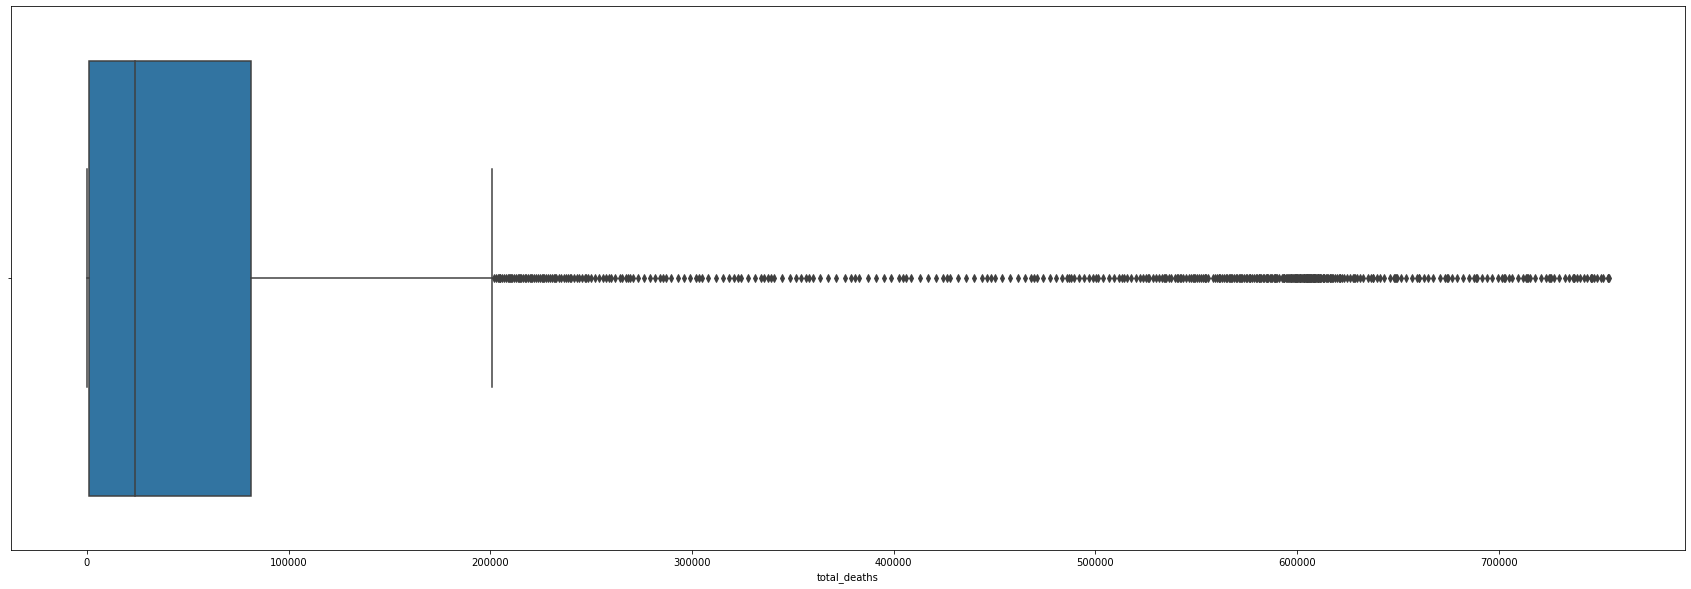

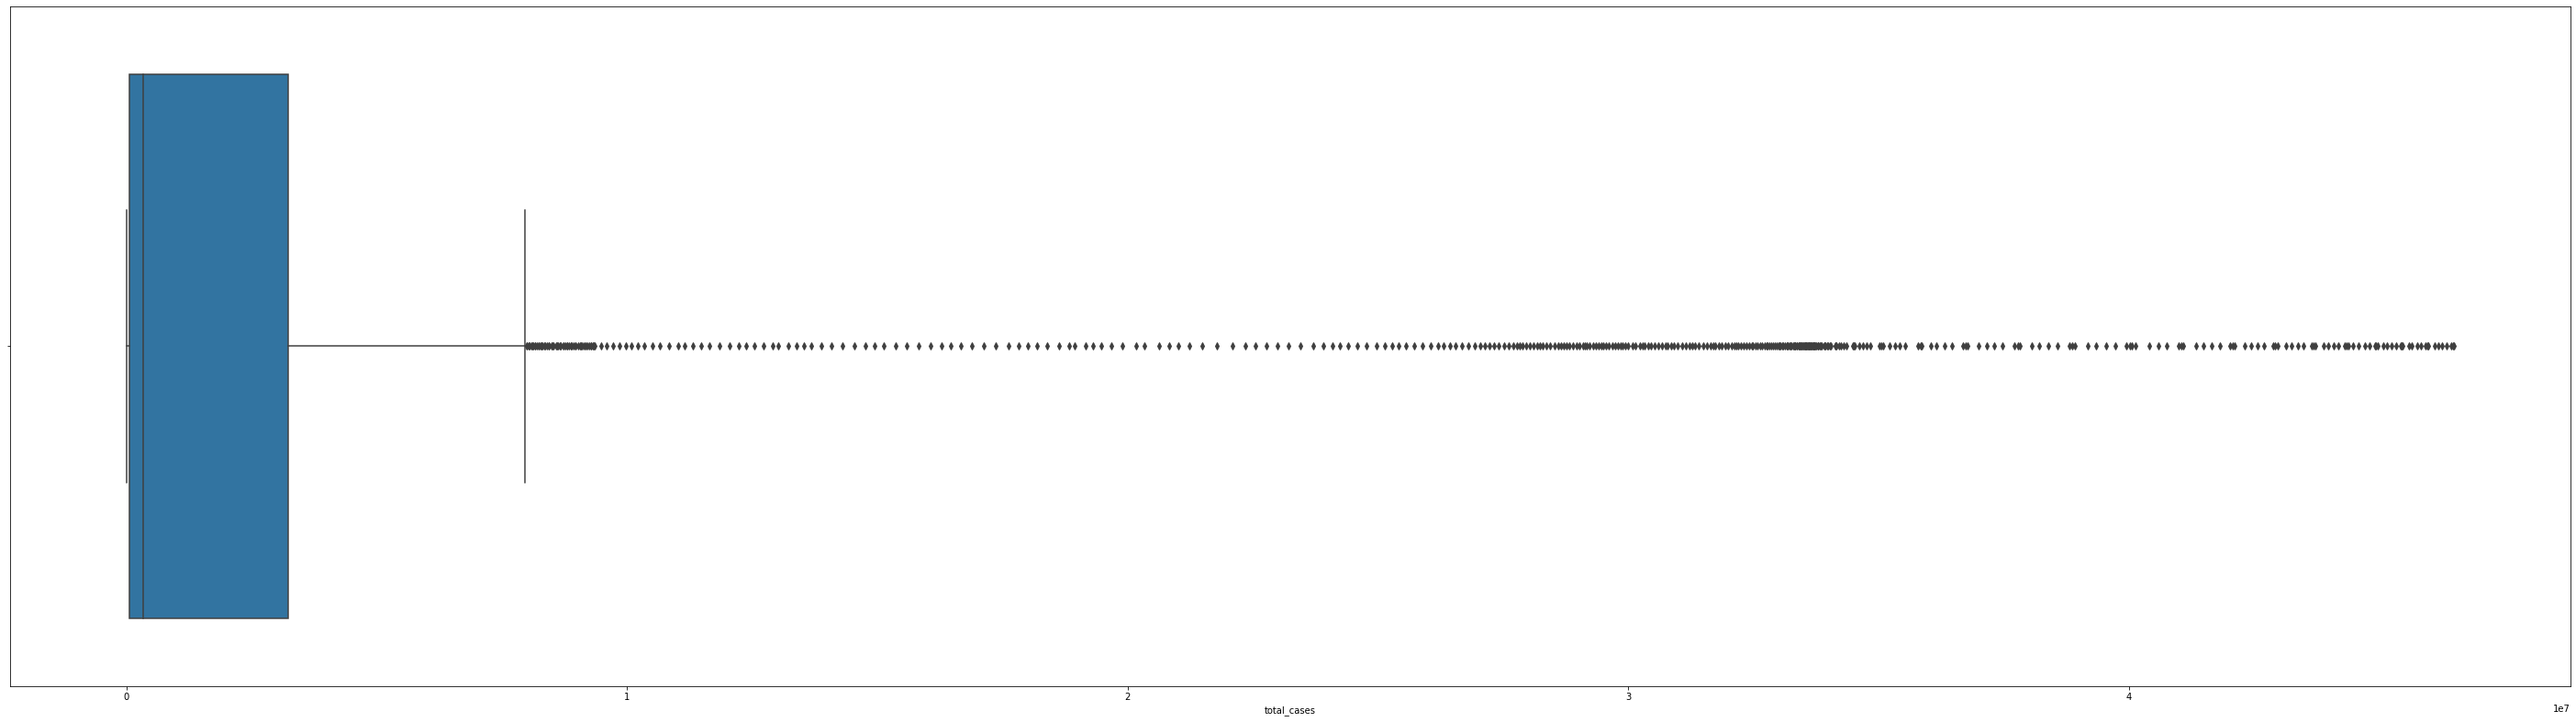

In [ ]:
#@title
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 1, 1)
sns.boxplot(data=datos_covid_8paises_outliers,x="total_deaths")
plt.show()

plt.figure(figsize=(50, 30))
plt.subplot(2, 1, 2)
sns.boxplot(data=datos_covid_8paises_outliers,x="total_cases")
plt.show()



*  *Primer gráfico de muertes totales*
*   *Segundo gráfico de casos totales*




**Elegimos las columnas que deseamos imputar y sacar los outliers para luego imputar**

In [ ]:
#@title
list(datos_covid_8paises_outliers.columns.values)

['location',
 'date',
 'total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'reproduction_rate',
 'stringency_index',
 'population',
 'gdp_per_capita']

In [ ]:
col_imputacion = ['total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'reproduction_rate',
 'stringency_index',
 'population',
 'gdp_per_capita']
for col in col_imputacion:

  desviacion_estandard = datos_covid_8paises_outliers[col].std()
  media = datos_covid_8paises_outliers[col].mean()

  res = (datos_covid_8paises_outliers[col] > media + desviacion_estandard*3) | (datos_covid_8paises_outliers[col] < media - desviacion_estandard*3) | (datos_covid_8paises_outliers[col] < 0)
  datos_covid_8paises_outliers.loc[res,col]=np.nan

In [ ]:
for columna in col_imputacion:
  datos_covid_8paises_outliers[columna].fillna(datos_covid_8paises_outliers[columna].median()) 

###Valores faltantes

**Una vez obtenidas todas las columnas necesarias, cada una cuenta con valores faltantes que se van a necesitar imputar o eliminar.**

In [ ]:
#@title
percent_missing = datos_covid_8paises_outliers.isna().sum() * 100 / len(datos_covid_8paises_outliers)
percent_missing.sort_values(ascending=False)

total_deaths                10.288145
new_deaths                   8.605686
new_deaths_per_million       8.025527
reproduction_rate            7.774125
total_deaths_per_million     5.337459
total_cases                  5.008702
new_cases                    3.016825
new_cases_per_million        1.933862
stringency_index             0.560820
gdp_per_capita               0.000000
population                   0.000000
total_cases_per_million      0.000000
date                         0.000000
location                     0.000000
dtype: float64

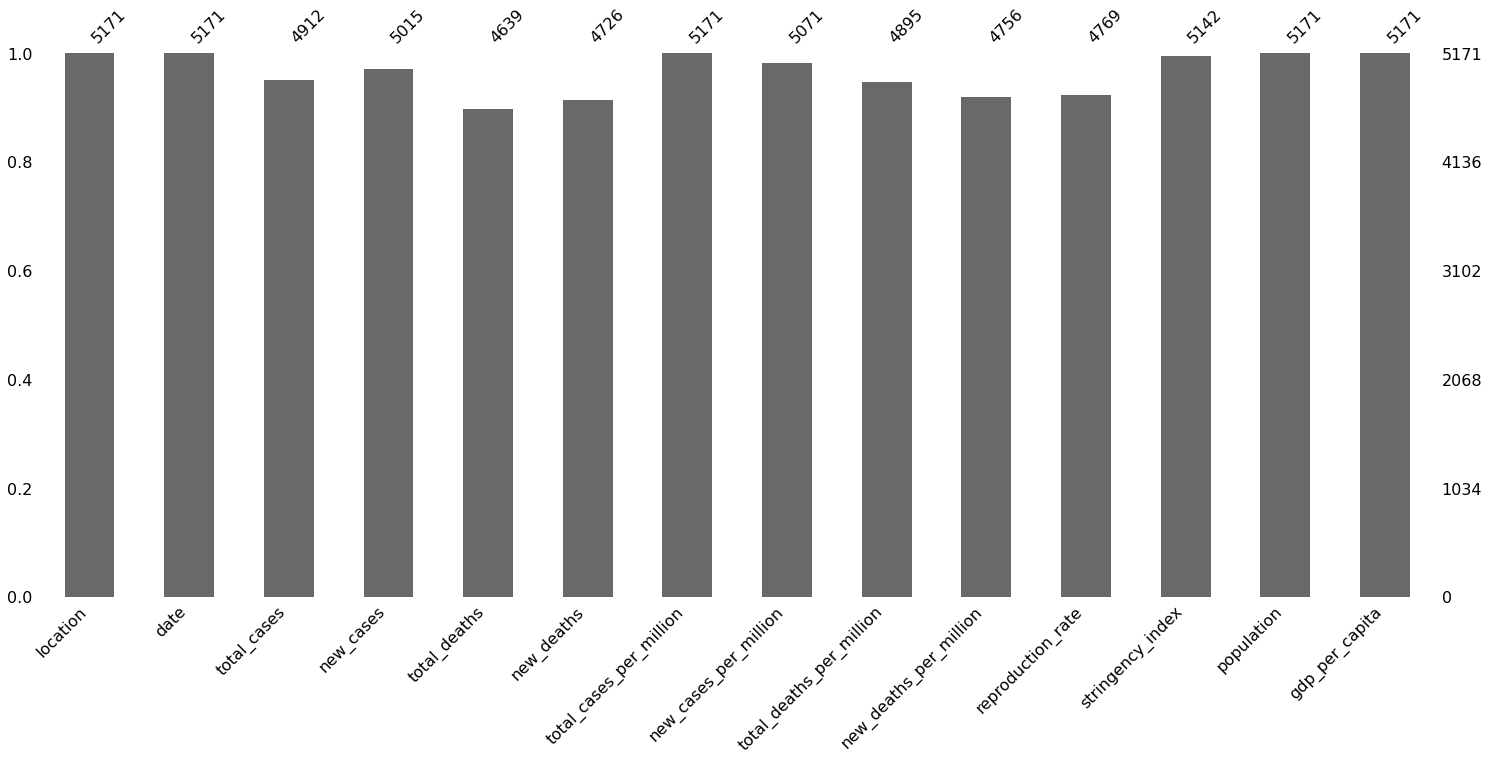

In [ ]:
#@title
msno.bar(datos_covid_8paises_outliers)

*Gráfico de barras de datos faltantes: Nos brinda una visualización que nos permite reconocer la proporción de los datos faltantes, debido a que su magnitud es pequeña en vez de imputar se proseguirá a eliminar las columnas que posean faltantes.*

**Eliminación de instancias con valores faltantes**

In [ ]:
datos_covid_8paises_outliers_clean = datos_covid_8paises_outliers.dropna()

In [ ]:
#@title
datos_covid_8paises_outliers_clean.shape

(4158, 14)

In [ ]:
#@title
percent_missing = datos_covid_8paises_outliers_clean.isna().sum() * 100 / len(datos_covid_8paises_outliers_clean)
percent_missing.sort_values(ascending=False)

gdp_per_capita              0.0
population                  0.0
stringency_index            0.0
reproduction_rate           0.0
new_deaths_per_million      0.0
total_deaths_per_million    0.0
new_cases_per_million       0.0
total_cases_per_million     0.0
new_deaths                  0.0
total_deaths                0.0
new_cases                   0.0
total_cases                 0.0
date                        0.0
location                    0.0
dtype: float64

##Análisis exploratorio

Se analizarán ocho países que fueron elegidos por su actual buen desempeño frente al COVID-19, teniendo en cuenta que pertenecen todos a la misma zona y pueden contar con las características económicas y sociales más parecidas, esto luego se verá que no es fundamento suficiente ya que por más parecidas que sean, los factores no son iguales y por lo tanto muy rara vez puede el virus ser analizado de igual manera para dos países. Se tomaron en cuenta cuatro países que aplicaron el uso de barbijo obligatorio en el transcurso de Abril y Mayo, y cuatro países que no aplicaron esta política. El período importa ya que podría decirse que todos los países en cuestión aplicaron las mismas políticas sólo que en distintos tiempos.

In [ ]:
#@title
datos_covid_8paises_outliers_analisis = datos_covid_8paises_outliers.copy()

In [ ]:
#@title
datos_covid_8paises_outliers_analisis

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita
0,Canada,2020-01-26,1.0,1.0,NaN,NaN,0.026,0.026,NaN,NaN,NaN,2.78,38067913.0,44017.591
1,Canada,2020-01-27,1.0,0.0,NaN,NaN,0.026,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
2,Canada,2020-01-28,2.0,1.0,NaN,NaN,0.053,0.026,NaN,NaN,NaN,2.78,38067913.0,44017.591
3,Canada,2020-01-29,2.0,0.0,NaN,NaN,0.053,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
4,Canada,2020-01-30,2.0,0.0,NaN,NaN,0.053,0.000,NaN,NaN,NaN,2.78,38067913.0,44017.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,United States,2021-11-03,NaN,84369.0,NaN,NaN,138947.556,253.425,2254.100,5.725,0.99,56.02,332915074.0,54225.446
5167,United States,2021-11-04,NaN,81566.0,NaN,1131.0,139192.562,245.005,2257.498,3.397,1.00,56.02,332915074.0,54225.446
5168,United States,2021-11-05,NaN,96665.0,NaN,NaN,139482.921,290.359,2264.620,7.122,1.00,56.02,332915074.0,54225.446
5169,United States,2021-11-06,NaN,29856.0,NaN,384.0,139572.602,89.681,2265.773,1.153,NaN,NaN,332915074.0,54225.446


**Descripción general de los valores de features obtenidos:**

In [ ]:
#@title
datos_covid_8paises_outliers_analisis.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita
count,4.912000e+03,5015.000000,4639.000000,4726.000000,5171.000000,5071.000000,4895.000000,4756.000000,4769.000000,5142.000000,5.171000e+03,5171.000000
mean,1.834484e+06,9294.356132,45614.286053,164.808929,34606.752296,124.392341,752.710395,1.821930,1.067196,56.563726,7.257503e+07,45308.445042
std,3.519969e+06,17282.382731,69365.990161,320.368767,38302.687515,165.253000,654.208643,2.604982,0.246364,18.355772,1.021309e+08,9156.096553
min,1.000000e+00,0.000000,1.000000,0.000000,0.003000,0.000000,0.003000,0.000000,0.450000,2.780000,5.465629e+06,34272.360000
25%,5.945250e+04,179.500000,900.000000,1.000000,3248.026500,11.750000,156.443000,0.015000,0.890000,46.760000,1.016016e+07,38605.671000
50%,2.724210e+05,1055.000000,18887.000000,20.000000,17455.928000,60.558000,582.471000,0.689000,1.050000,62.040000,4.674521e+07,40585.721000
75%,2.110910e+06,8917.500000,70291.000000,149.000000,63766.875500,159.542000,1409.948000,2.564250,1.210000,69.440000,6.820711e+07,46949.283000
max,2.823882e+07,114800.000000,506979.000000,1847.000000,139638.588000,810.543000,2266.130000,13.415000,2.170000,87.960000,3.329151e+08,64800.057000


In [ ]:
#@title
paises=datos_covid_8paises_outliers_analisis['location'] 
confirmados=datos_covid_8paises_outliers_analisis['total_cases'] 
nuevos_casos = datos_covid_8paises_outliers_analisis['new_cases']
muertes_totales = datos_covid_8paises_outliers_analisis['total_deaths']
nuevas_muertes = datos_covid_8paises_outliers_analisis['new_deaths']
restriccion = datos_covid_8paises_outliers_analisis['stringency_index']
reproduccion = datos_covid_8paises_outliers_analisis['reproduction_rate']

In [ ]:
#@title
paises

0              Canada
1              Canada
2              Canada
3              Canada
4              Canada
            ...      
5166    United States
5167    United States
5168    United States
5169    United States
5170    United States
Name: location, Length: 5171, dtype: object

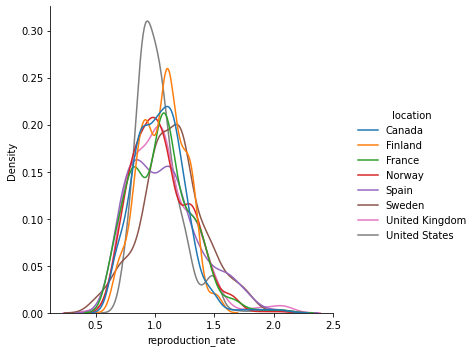

In [ ]:
#@title
sns.displot(datos_covid_8paises_outliers_analisis, x="reproduction_rate", hue="location", kind="kde")

*Gráfico de la tasa de reproducción del virus por país*

In [ ]:
#@title
result_df = datos_covid_8paises_outliers_analisis.drop_duplicates(subset=["location", "population","gdp_per_capita"], keep='first')
print(result_df)

            location       date  ...   population  gdp_per_capita
0             Canada 2020-01-26  ...   38067913.0       44017.591
652          Finland 2020-01-29  ...    5548361.0       40585.721
1301          France 2020-01-24  ...   67564251.0       38605.671
1955          Norway 2020-02-26  ...    5465629.0       64800.057
2576           Spain 2020-02-01  ...   46745211.0       34272.360
3222          Sweden 2020-02-01  ...   10160159.0       46949.283
3868  United Kingdom 2020-01-31  ...   68207114.0       39753.244
4515   United States 2020-01-22  ...  332915074.0       54225.446

[8 rows x 14 columns]


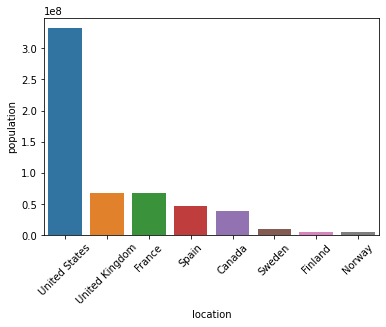

In [ ]:
#@title
sns.barplot(x = "location",y = "population",data = result_df,order=result_df.sort_values("population",ascending = False).location)
plt.xticks(rotation=45)
# Show the plot
plt.show()

*Gráfico de la población por país*

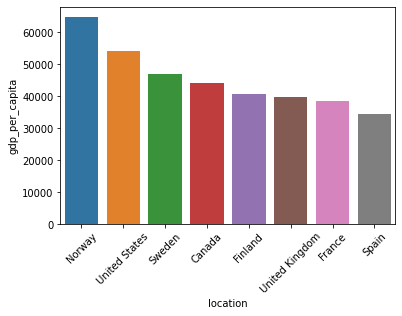

In [ ]:
#@title
sns.barplot(x = "location",y = "gdp_per_capita",data = result_df,order=result_df.sort_values("gdp_per_capita",ascending = False).location)
plt.xticks(rotation=45)
# Show the plot
plt.show()

*Gráfico del gdp per cápita por país*

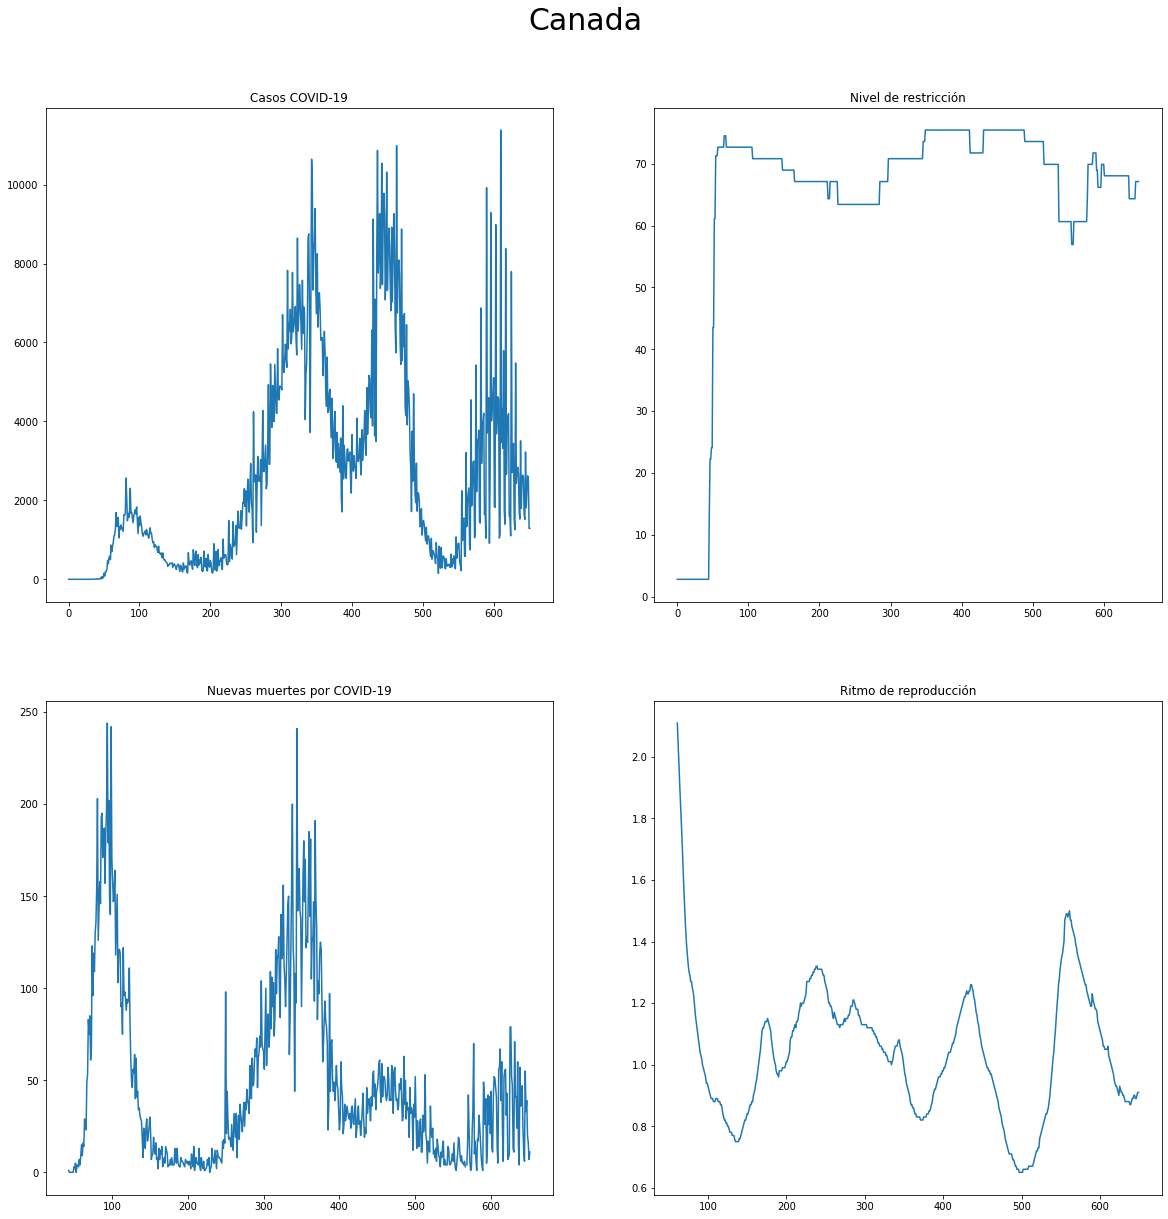

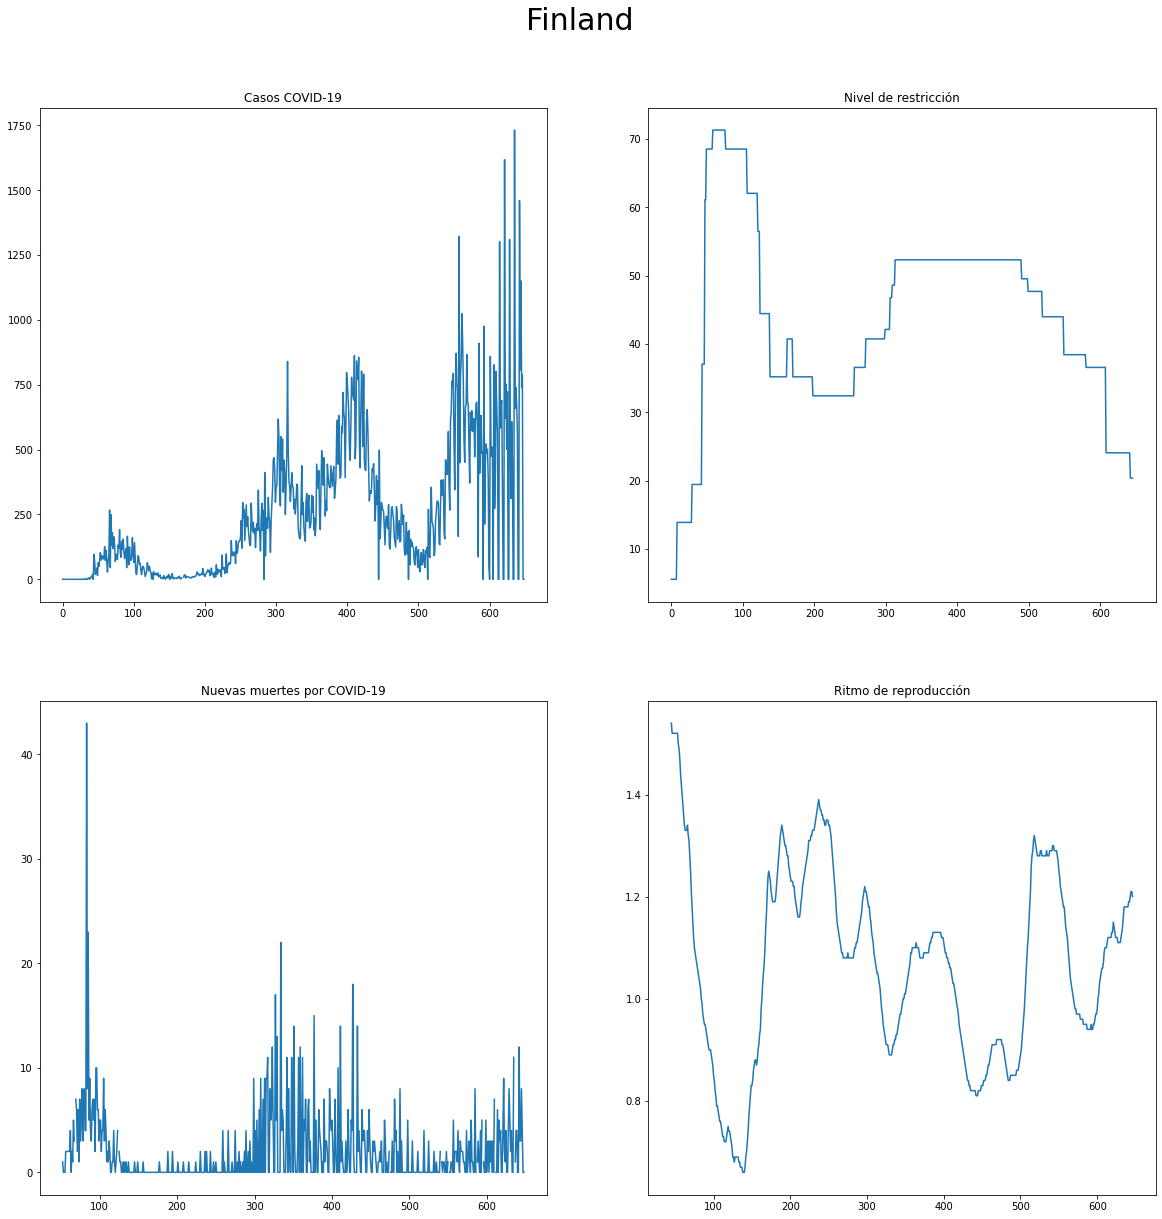

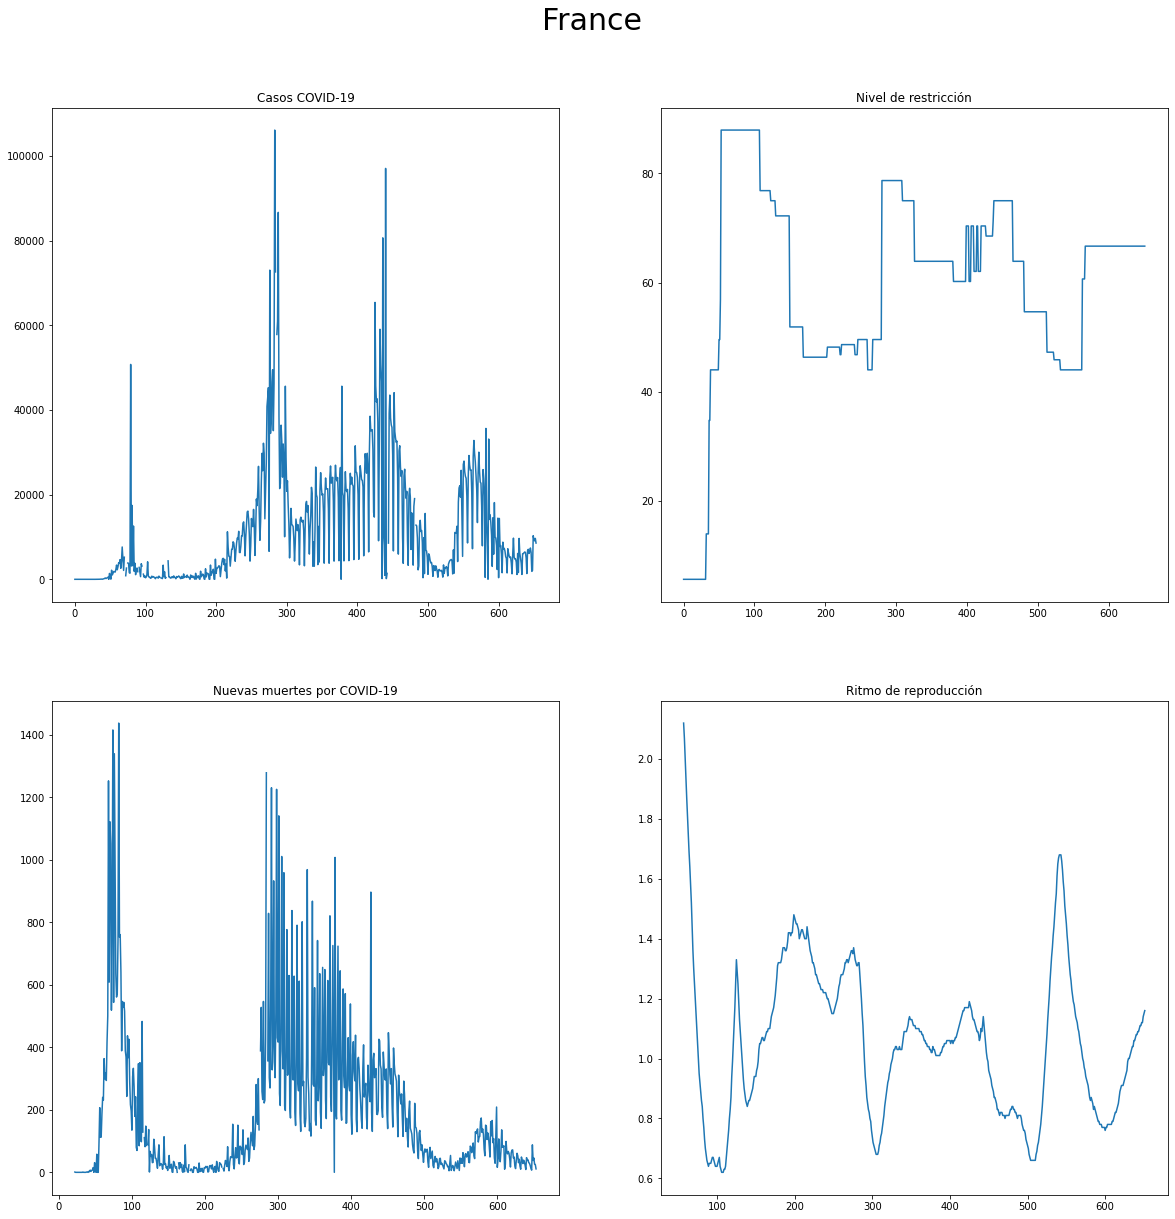

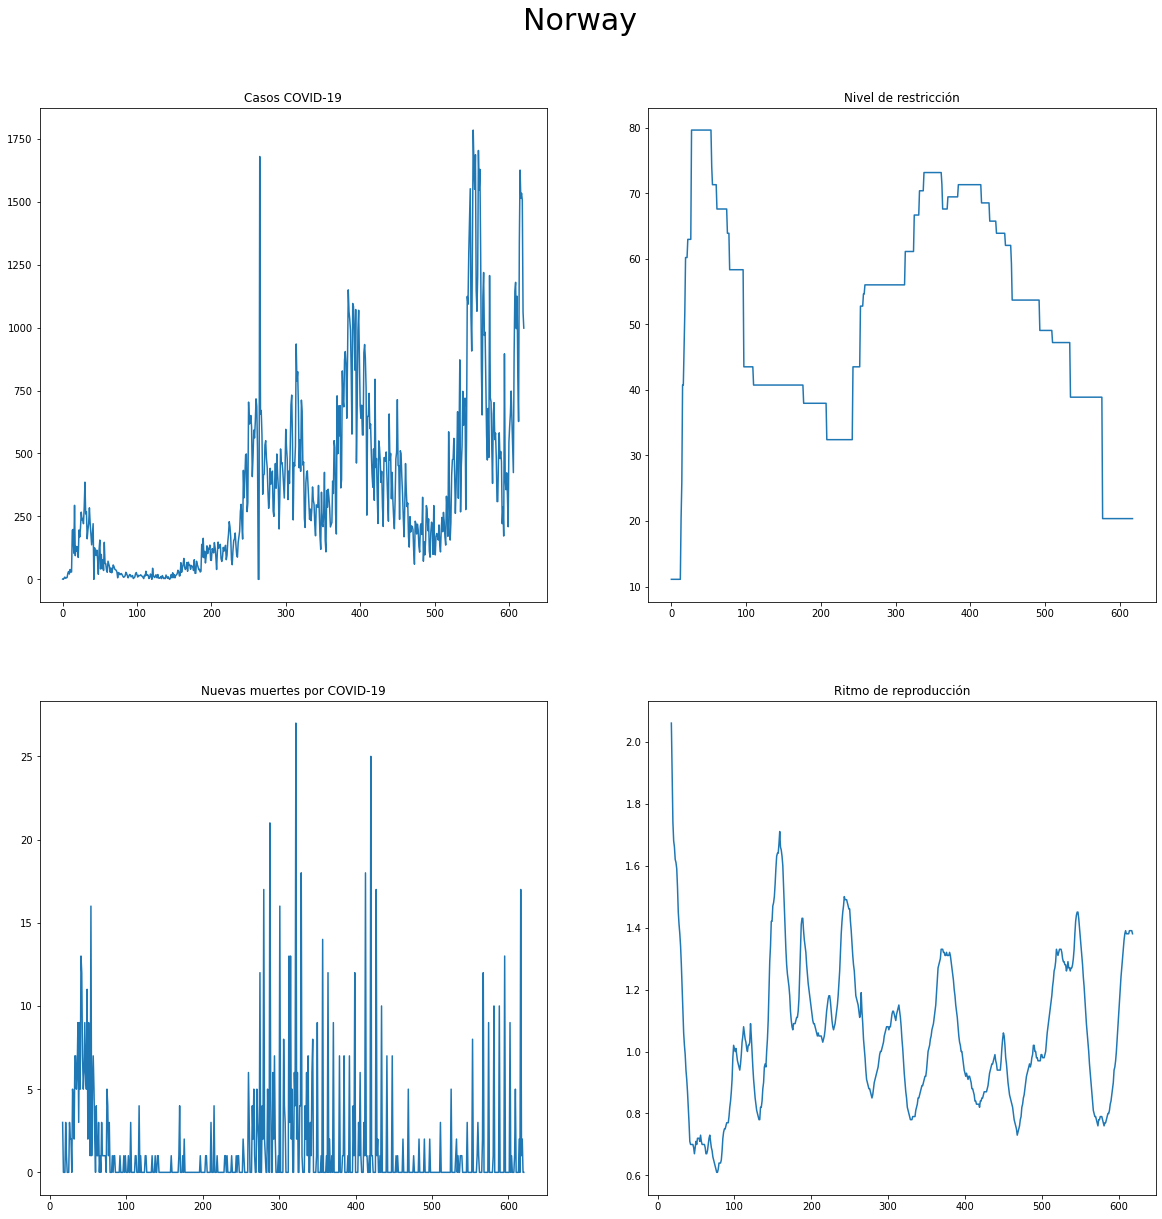

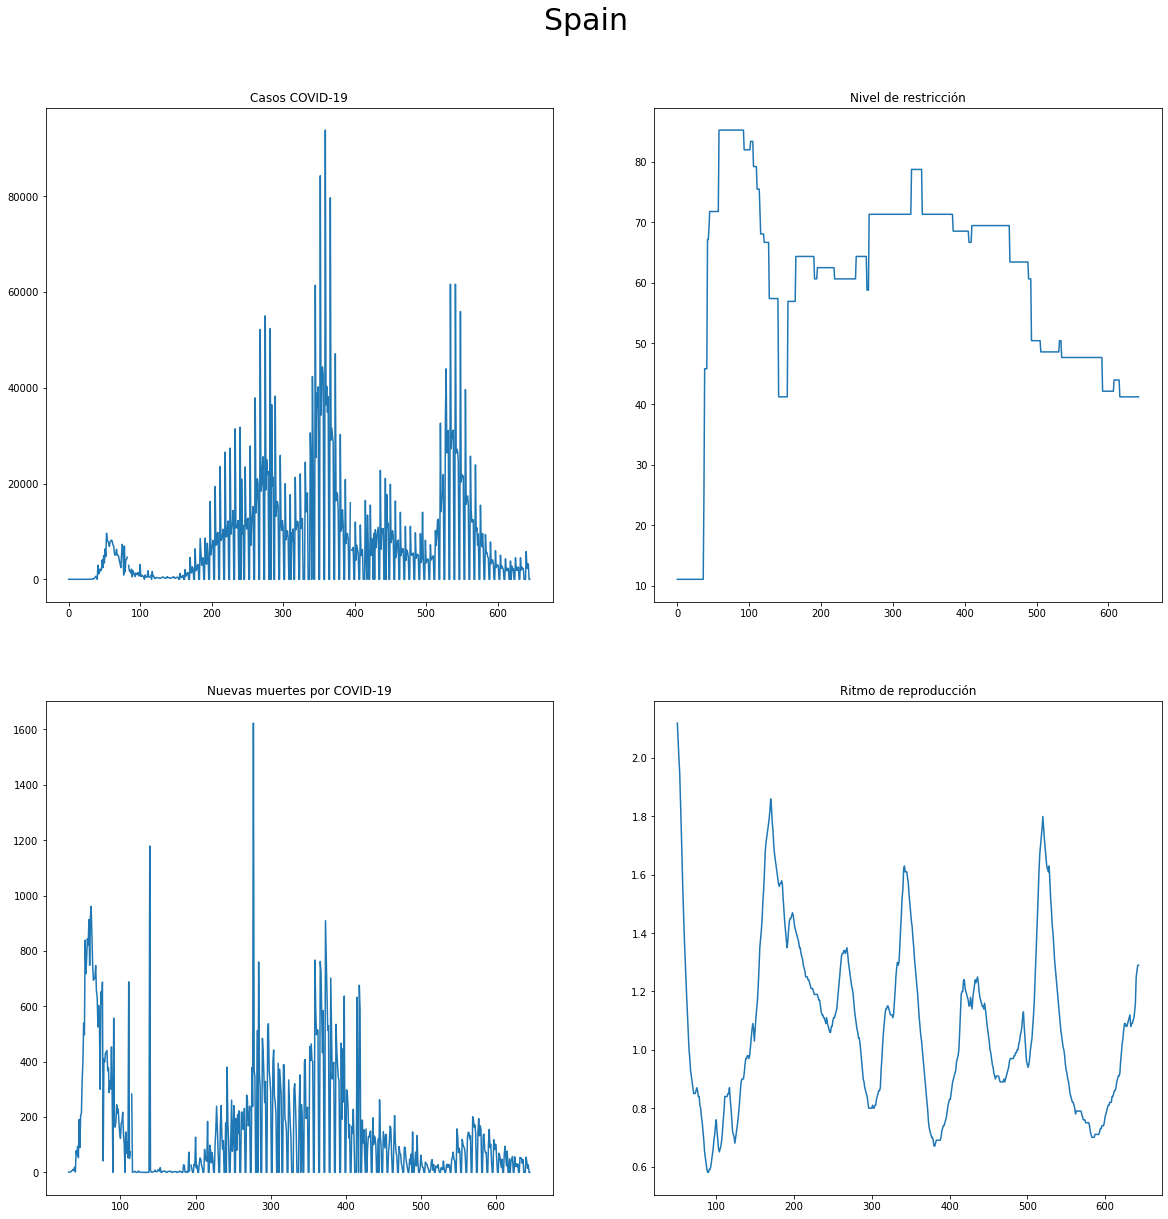

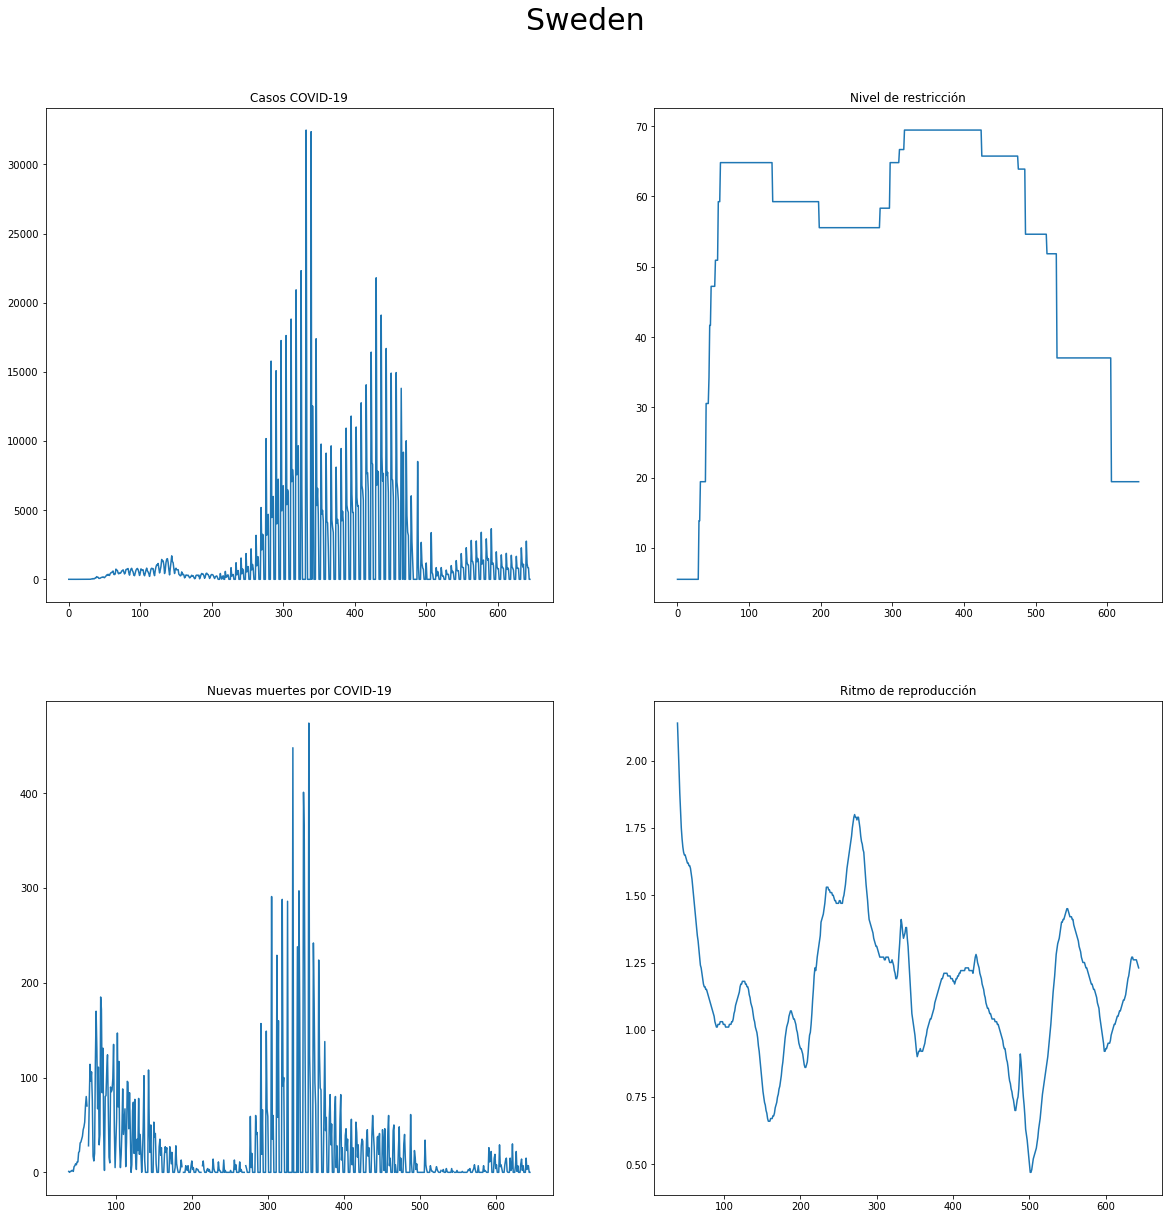

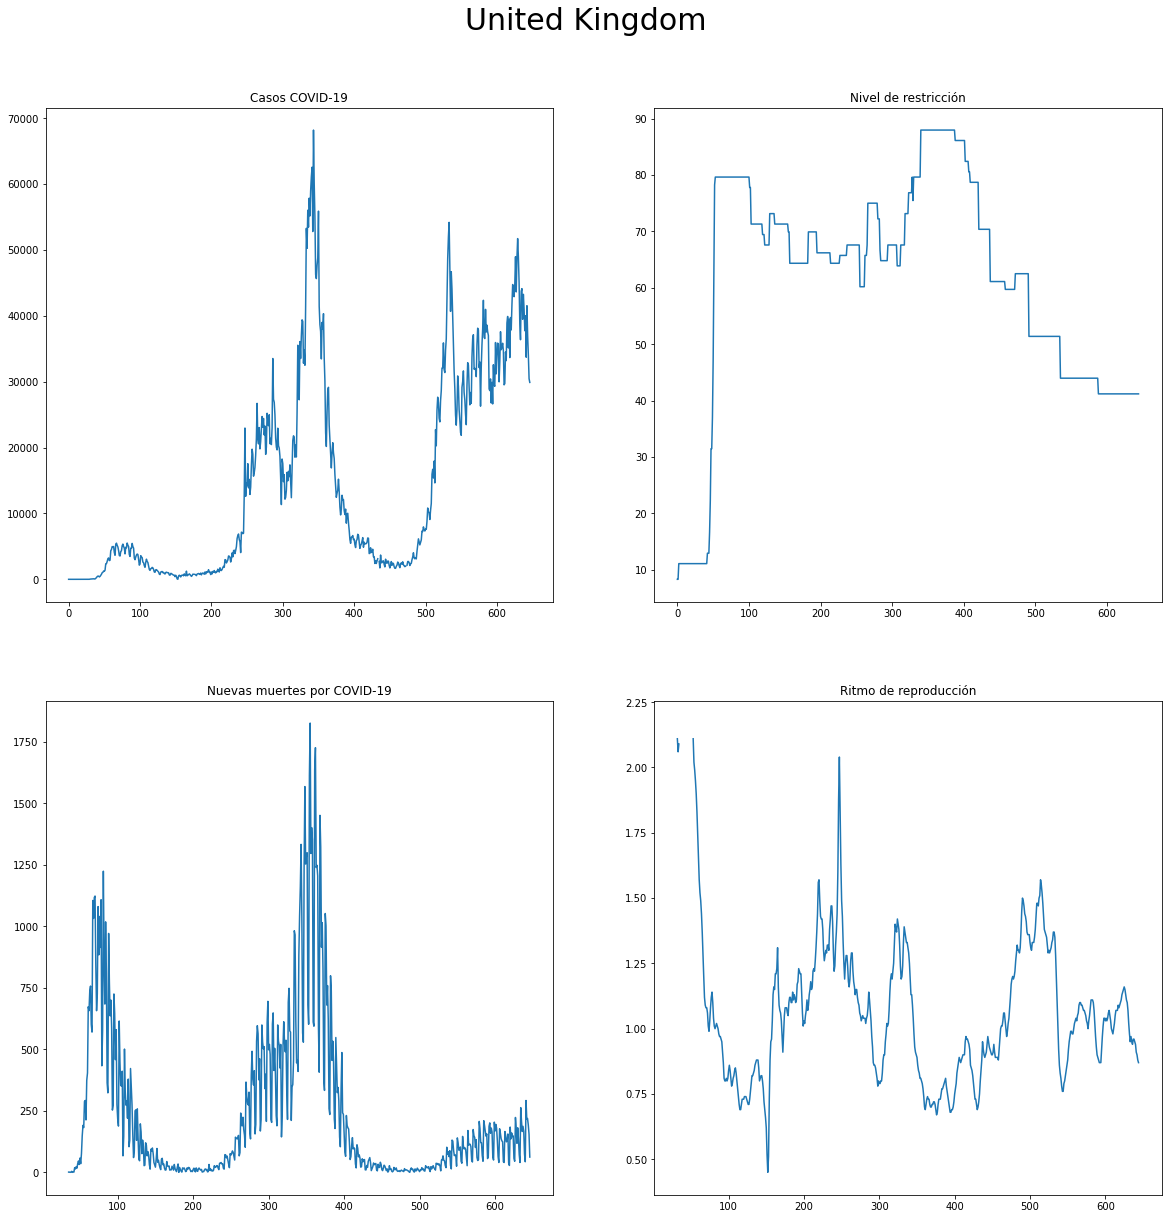

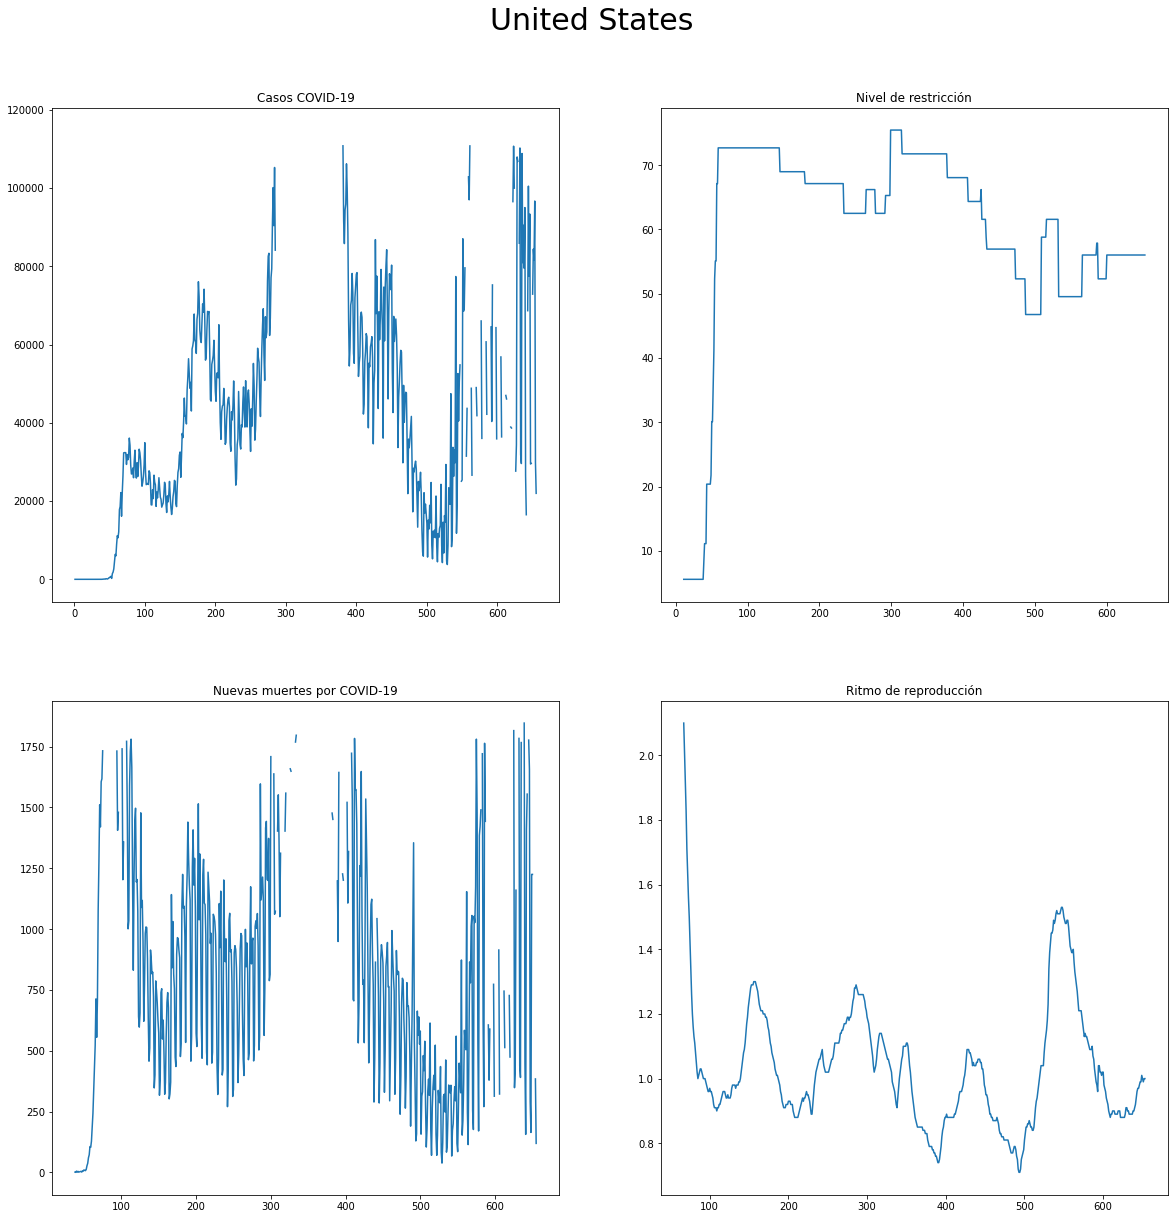

In [ ]:
#@title
for i in paises.unique():
  ind_cs=np.where(paises==i)
  ind_cs=ind_cs[0]
  restricciones=restriccion[ind_cs]
  casos_cs=nuevos_casos[ind_cs]
  repro=reproduccion[ind_cs]
  nuev_mu=nuevas_muertes[ind_cs]
  dias=np.arange(0,len(restricciones))
  fig, axs = plt.subplots(2, 2)
  fig.set_figheight(20)
  fig.set_figwidth(20)
  fig.suptitle(i,y=0.95,fontsize=30)
  # Casos Covid
  axs[0, 0].plot(dias, casos_cs)
  axs[0, 0].set_title("Casos COVID-19")
    
  # Nivel de restricción
  axs[0, 1].plot(dias, restricciones)
  axs[0, 1].set_title("Nivel de restricción")

  # Nuevas muertes
  axs[1, 0].plot(dias, nuev_mu)
  axs[1, 0].set_title("Nuevas muertes por COVID-19")

  # Ritmo de reproducción
  axs[1, 1].plot(dias, repro)
  axs[1, 1].set_title("Ritmo de reproducción")

*Gráficos principales de los distintos países elegidos*

###Análisis de comienzo de pandemia

####Análisis exploratorio: Francia

Text(0, 0.5, 'cantidad de casos')

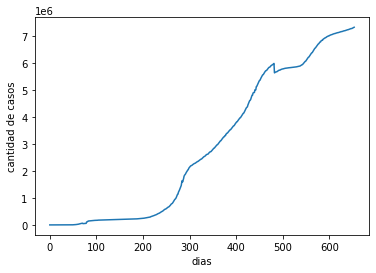

In [ ]:
#@title
ind_cs=np.where(paises=="France")
ind_cs=ind_cs[0]
casos_cs=confirmados[ind_cs]
dias=np.arange(0,len(casos_cs))
plt.plot(dias,casos_cs)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

*Gráfico de cantidad de casos acumulados*

Text(0, 0.5, 'cantidad de muertes')

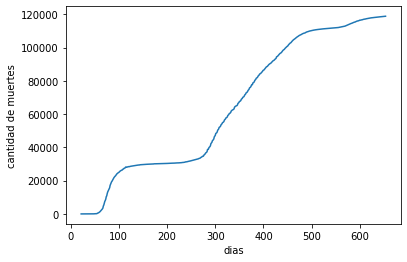

In [ ]:
#@title
casos_ms=muertes_totales[ind_cs]
dias_ms=np.arange(0,len(casos_ms))
plt.plot(dias_ms,casos_ms)
plt.xlabel('dias')
plt.ylabel('cantidad de muertes')

*Gráfico de cantidad de casos acumulados*

**Éstas curvas son de muertes y casos totales acumulados a lo largo del tiempo, para ver mejor la propagación debemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica.**


Text(0, 0.5, 'log cantidad de casos')

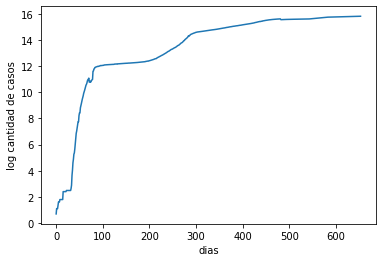

In [ ]:
#@title
plt.plot(dias,np.log(casos_cs))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico en escala logarítmica de cantidad de casos por día*

Text(0, 0.5, 'log cantidad de casos')

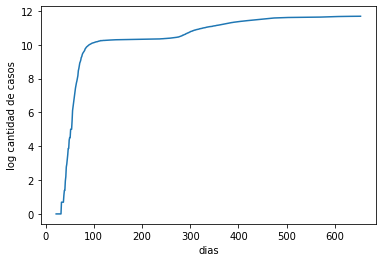

In [ ]:
#@title
plt.plot(dias_ms,np.log(casos_ms))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico en escala logarítmica de cantidad de muertes por día*

**Como referencia de primeros días, se tomarán 80 desde que se detectó el primer caso.**

Text(0, 0.5, 'log cantidad de casos')

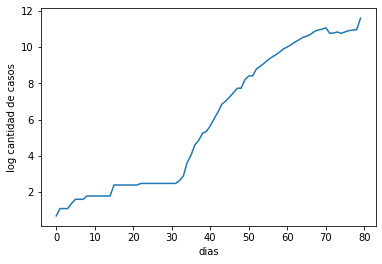

In [ ]:
#@title
casos_principio=casos_cs[0:80]
dias_principio=dias[0:80]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos en los primeros 80 días de pandemia*

Text(0, 0.5, 'log cantidad de casos')

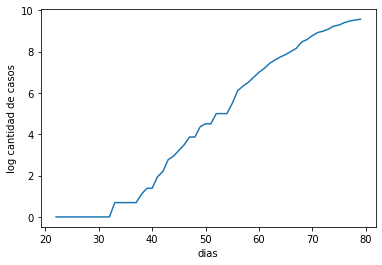

In [ ]:
#@title
casos_principio_ms=casos_ms[0:80]
dias_principio_ms=dias_ms[0:80]

plt.plot(dias_principio_ms,np.log(casos_principio_ms))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de muertes en los primeros 80 días de pandemia*

**Seleccionamos lo que sucede entre los días 35 y 65 días conforme al comportamiento más estable para los casos detectados y entre 40 y 70 para las muertes.**

Text(0, 0.5, 'cantidad de casos')

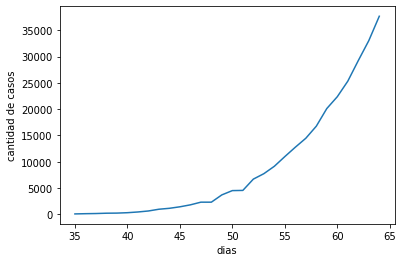

In [ ]:
#@title
casos_principio=casos_cs[35:65]
dias_principio=dias[35:65]
casos_principio_ms=casos_ms[40:70]
dias_principio_ms=dias_ms[40:70]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

*Gráfico cantidad de casos en 35 a 65 días después de primer caso*

Text(0, 0.5, 'cantidad de muertes')

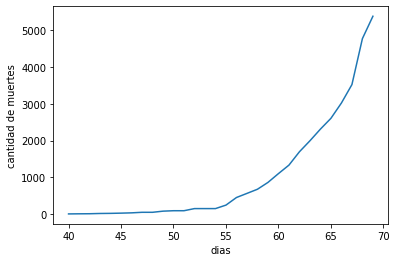

In [ ]:
#@title
plt.plot(dias_principio_ms,casos_principio_ms)
plt.xlabel('dias')
plt.ylabel('cantidad de muertes')

*Gráfico cantidad de muertes en 35 a 65 días después de primer caso*

Text(0, 0.5, 'log cantidad de casos')

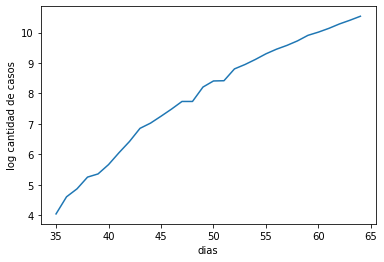

In [ ]:
#@title
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico cantidad de casos en 35 a 65 días después de primer caso en función logarítmica*

Text(0, 0.5, 'log cantidad de muertes')

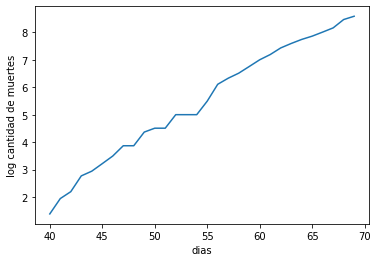

In [ ]:
#@title
plt.plot(dias_principio_ms,np.log(casos_principio_ms))
plt.xlabel('dias')
plt.ylabel('log cantidad de muertes')

*Gráfico cantidad de casos en 35 a 65 días después de primer caso en función logarítmica*

**Utilizamos la fórmula para poder calcular el K, utilizando el período que se eligió.**

$Confirmados=e^{k(t-t_0)}$ 



In [ ]:
#@title
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [ ]:
#@title
#Casos detectados
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.14836147, -7.25767611])

In [ ]:
#@title
#Muertes por covid
popt2, pcov2 = curve_fit(exponencial, dias_principio_ms, casos_principio_ms)
popt2

array([ 0.18486602, 22.43729008])

In [ ]:
#@title
#Array de K para luego sumar los demás países
kas=[]

**Comprobación con datos reales**

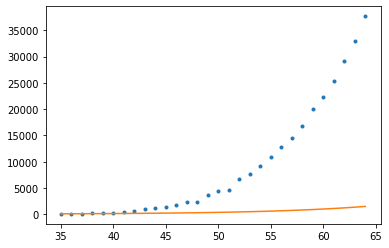

In [ ]:
#@title
kf=popt[0]
t0=popt[1]
kas.append(kf)
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

*Gráfico de casos por día del K, conforme a los datos reales*

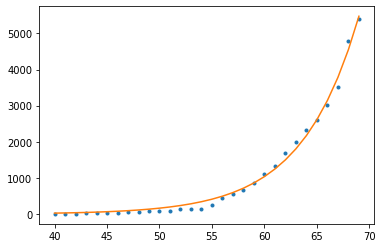

In [ ]:
#@title
k2=popt2[0]
t02=popt2[1]
casos_simu2=exponencial(dias_principio_ms,k2,t02)
plt.plot(dias_principio_ms,casos_principio_ms,'.')
plt.plot(dias_principio_ms,casos_simu2)

*Gráfico de muertes por día del K, conforme a los datos reales*

####Otros países
**Repetimos el proceso de cálculo de K con los demás países.**

#####España

Text(0, 0.5, 'log cantidad de casos')

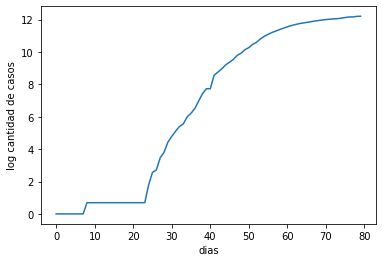

In [ ]:
#@title
ind_cs=np.where(paises=="Spain")#  Spain
ind_cs=ind_cs[0]
casos_cs=confirmados[ind_cs]
dias=np.arange(0,len(casos_cs))
casos_principio=casos_cs[0:80]
dias_principio=dias[0:80]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos a lo largo de los días en función logarítmica*

Text(0, 0.5, 'log cantidad de casos')

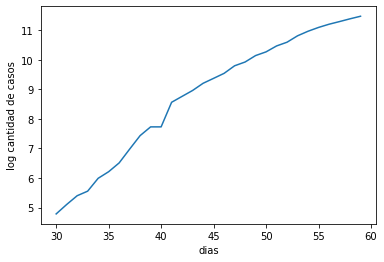

In [ ]:
#@title
casos_principio=casos_cs[30:60]
dias_principio=dias[30:60]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos en un período de los primeros 30 a 60 días*

In [ ]:
#@title

popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([  0.14241518, -22.15096677])

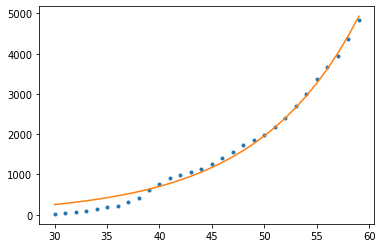

In [ ]:
#@title

ke=popt[0]
kas.append(ke)
t0=popt[1]
casos_simu=exponencial(dias_principio,ke,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

*Gráfico de casos por día del K, conforme a los datos reales*

#####United Kingdom

Text(0, 0.5, 'log cantidad de casos')

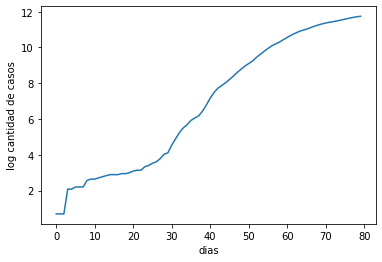

In [ ]:
#@title
ind_cs=np.where(paises=="United Kingdom")#  United Kingdom
ind_cs=ind_cs[0]
casos_cs=confirmados[ind_cs]
dias=np.arange(0,len(casos_cs))
casos_principio=casos_cs[0:80]
dias_principio=dias[0:80]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos a lo largo de los días en función logarítmica*

Text(0, 0.5, 'log cantidad de casos')

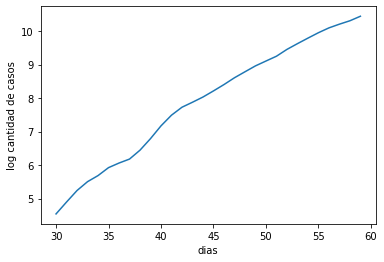

In [ ]:
#@title
casos_principio=casos_cs[30:60]
dias_principio=dias[30:60]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos en un período de los primeros 30 a 60 días*

In [ ]:
#@title

popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.15212664, -9.94373378])

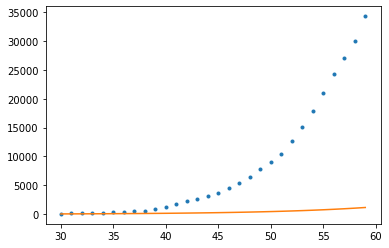

In [ ]:
#@title

ku=popt[0]
kas.append(ku)
t0=popt[1]
casos_simu=exponencial(dias_principio,ku,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

*Gráfico de casos por día del K, conforme a los datos reales*

#####Canada

Text(0, 0.5, 'log cantidad de casos')

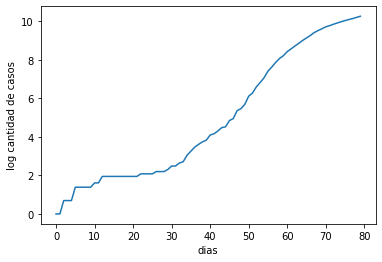

In [ ]:
#@title
ind_cs=np.where(paises=="Canada")
ind_cs=ind_cs[0]
casos_cs=confirmados[ind_cs]
dias=np.arange(0,len(casos_cs))
casos_principio=casos_cs[0:80]
dias_principio=dias[0:80]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos a lo largo de los días en función logarítmica*

Text(0, 0.5, 'log cantidad de casos')

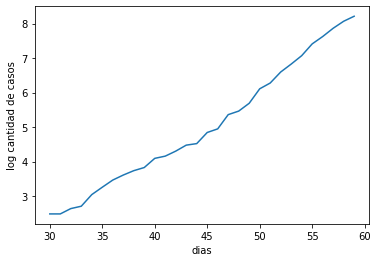

In [ ]:
#@title
casos_principio=casos_cs[30:60]
dias_principio=dias[30:60]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos en un período de los primeros 30 a 60 días*

In [ ]:
#@title
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.23032644, 23.12324624])

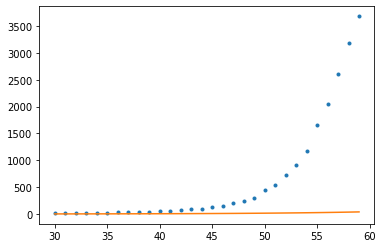

In [ ]:
#@title

kc=popt[0]
t0=popt[1]
kas.append(kc)
casos_simu=exponencial(dias_principio,kc,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

*Gráfico de casos por día del K, conforme a los datos reales*

#####Sweden

Text(0, 0.5, 'log cantidad de casos')

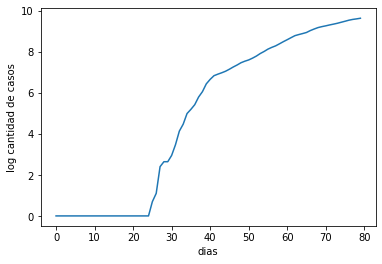

In [ ]:
#@title
ind_cs=np.where(paises=="Sweden")
ind_cs=ind_cs[0]
casos_cs=confirmados[ind_cs]
dias=np.arange(0,len(casos_cs))
casos_principio=casos_cs[0:80]
dias_principio=dias[0:80]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos a lo largo de los días en función logarítmica*

Mejor nos quedamos con lo que sucede entre los días 30 y 60, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'log cantidad de casos')

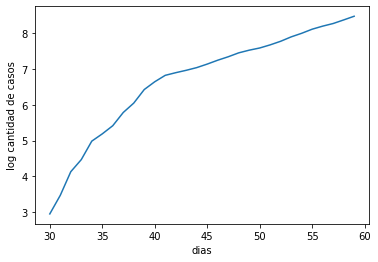

In [ ]:
#@title
casos_principio=casos_cs[30:60]
dias_principio=dias[30:60]

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

*Gráfico de cantidad de casos en un período de los primeros 30 a 60 días*

In [ ]:
#@title
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([  0.10248567, -23.97013434])

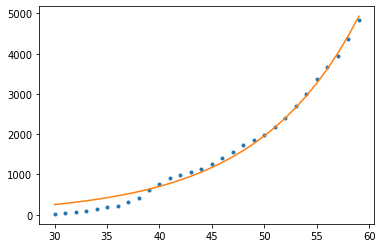

In [ ]:
#@title

ksw=popt[0]
t0=popt[1]
kas.append(ksw)
casos_simu=exponencial(dias_principio,ksw,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

*Gráfico de casos por día del K, conforme a los datos reales*

####Intervalo de confianza

In [ ]:
#@title
ksdf = pd.DataFrame(kas)
ksdf

,0
0,0.148361
1,0.142415
2,0.152127
3,0.230326
4,0.102486


In [ ]:
#@title
alpha = 5
medias = np.apply_along_axis(np.mean, 1, ksdf)
medias.sort()
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias,(100-alpha/2))
intervalo_confianza = [inferior,superior]
print("Intervalo de confianza:",intervalo_confianza)

Intervalo de confianza: [0.10647862339099329, 0.22250645967249483]


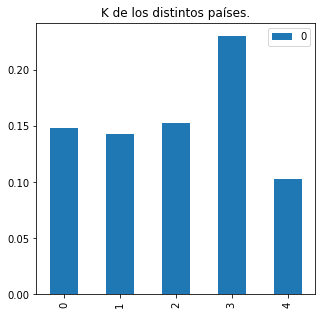

In [ ]:
#@title
ksdf.plot(kind="bar",figsize=(5,5),title="K de los distintos países.")

*Gráfico de k para distintos países.*

Más allá de que los países sean similares, hay datos que no se poseen o que no se agregan a la ecuación como el `COVID-19 en distintas estaciones` y el `COVID-19 en países con mayor o menor desarrollo`. Esto se analizará a continuación y es lo que en parte demuestra que hay variables que no se están considerando para el cálcuo de k y por lo tanto sería imposible estimar un valor preciso para una situación tan general como el k en todo el mundo, se puede hacer un promedio, pero no se podría aplicar para cada país.

###COVID-19 Frente a estaciones

**¿Podría la ubicación afectar el análisis de propagación del virus?**

A continuación se analizarán distintos países de regiones separadas con estaciones en tiempos diferentes y se hará una comparación con la tasa de reproducción del virus en el transcurso de un año.

In [ ]:
#@title
mask = (datos_covid['date'] > "2020-04-04") & (datos_covid['date'] <= "2021-04-04")

In [ ]:
#@title
datos_covid = datos_covid.loc[mask].copy()

In [ ]:
#@title
datos_covid

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita
41,Afghanistan,2020-04-05,299.0,29.0,7.0,2.0,7.506,0.728,0.176,0.050,1.49,78.70,39835428.0,1803.987
42,Afghanistan,2020-04-06,337.0,38.0,7.0,0.0,8.460,0.954,0.176,0.000,1.49,78.70,39835428.0,1803.987
43,Afghanistan,2020-04-07,367.0,30.0,11.0,4.0,9.213,0.753,0.276,0.100,1.48,78.70,39835428.0,1803.987
44,Afghanistan,2020-04-08,423.0,56.0,14.0,3.0,10.619,1.406,0.351,0.075,1.48,78.70,39835428.0,1803.987
45,Afghanistan,2020-04-09,444.0,21.0,15.0,1.0,11.146,0.527,0.377,0.025,1.48,78.70,39835428.0,1803.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131488,Zimbabwe,2021-03-31,36882.0,43.0,1523.0,3.0,2443.784,2.849,100.913,0.199,1.02,57.41,15092171.0,1899.775
131489,Zimbabwe,2021-04-01,36896.0,14.0,1523.0,0.0,2444.711,0.928,100.913,0.000,1.03,57.41,15092171.0,1899.775
131490,Zimbabwe,2021-04-02,36903.0,7.0,1524.0,1.0,2445.175,0.464,100.980,0.066,1.06,57.41,15092171.0,1899.775
131491,Zimbabwe,2021-04-03,36911.0,8.0,1524.0,0.0,2445.705,0.530,100.980,0.000,1.11,57.41,15092171.0,1899.775


In [ ]:
#@title
datos_covid_10paises_analisis_plot = datos_covid[datos_covid['location'].isin(["Italy","France","Spain","United Kingdom","Germany"]) ].copy()

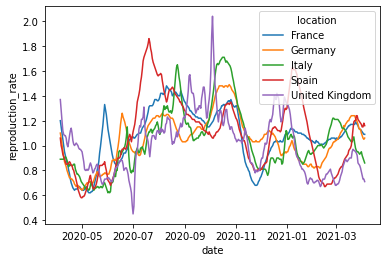

In [ ]:
#@title
sns.lineplot(x = datos_covid_10paises_analisis_plot["date"], y = datos_covid_10paises_analisis_plot["reproduction_rate"],hue=datos_covid_10paises_analisis_plot["location"])

*Gráfico de países europeos: Se puede observar como hay una baja de la tasa en verano que se encuentra entre Junio y Agosto, aumentando cada que se acerca más al Otoño.*

In [ ]:
#@title
datos_covid_10paises_analisis_plot2 = datos_covid[datos_covid['location'].isin(["Argentina","Chile","Bolivia","Paraguay","Uruguay"]) ].copy()

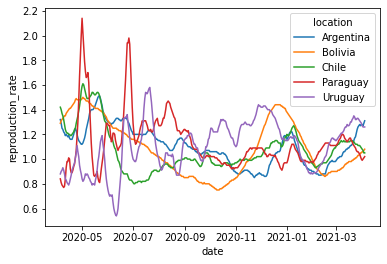

In [ ]:
#@title
sns.lineplot(x = datos_covid_10paises_analisis_plot2["date"], y = datos_covid_10paises_analisis_plot2["reproduction_rate"],hue=datos_covid_10paises_analisis_plot2["location"])

*Gráfico de países sudamericanos: A diferencia de Europa, hay una alta tasa en las fechas de invierno que se encuentran entre Junio y Agosto, disminuyendo cada que se acercan a la primavera.*

###COVID-19 por GDP 

**¿Podría el GDP per cápita afectar el análisis de propagación del virus?**

A menudo ser considerado un país con altos ingresos puede resultar beneficioso, ya que las personas cuentan con más recursos de cuidado propio, esto se analizará a continuación con una comparación de gdp per cápita en conjunto a los casos totales de cada uno de los países. 

In [ ]:
#@title
 datos_covid_10paises_analisis_plot2 = datos_covid[datos_covid['location'].isin(["Italy","France","Spain","United Kingdom","Germany"]) ].copy()

In [ ]:
#@title
result_df2 = datos_covid_10paises_analisis_plot2.drop_duplicates(subset=["location", "population","gdp_per_capita"], keep='first')

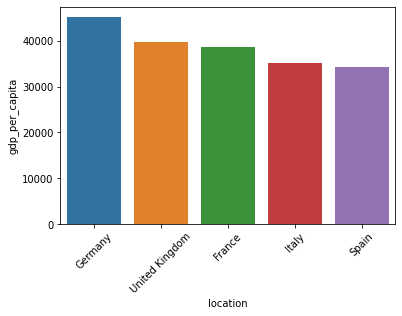

In [ ]:
#@title
sns.barplot(x = "location",y = "gdp_per_capita",data = result_df2,order=result_df2.sort_values("gdp_per_capita",ascending = False).location)
plt.xticks(rotation=45)
# Show the plot
plt.show()

*Gráfico de gdp per cápita por país*

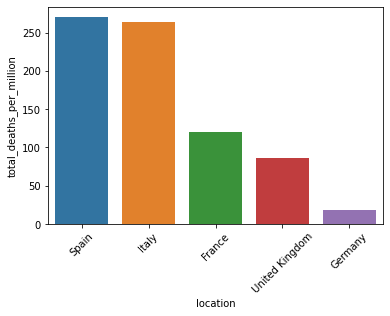

In [ ]:
#@title
sns.barplot(x = "location",y = "total_deaths_per_million",data = result_df2,order=result_df2.sort_values("total_deaths_per_million",ascending = False).location)
plt.xticks(rotation=45)
# Show the plot
plt.show()

*Gráfico de muertes totales por millón*

##Evaluando estrategias

###Modelo: Regresión logística

**Uso de máscaras obligatorio**: Estados Unidos, Canadá, Francia, España

**Uso de máscaras no obligatorio**: Suecia, Noruega, Reino unido, Finlandia

**Definimos las métricas que vamos a utilizar para evaluar el modelo**

In [ ]:
def metricas(y_train_pred,y_test_pred):
  MSE_train = mean_squared_error(y_train, y_train_pred)
  MSE_test = mean_squared_error(y_test, y_test_pred)

  RMSE_train = mean_squared_error(y_train, y_train_pred, squared=False)
  RMSE_test = mean_squared_error(y_test, y_test_pred, squared=False)

  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test = mean_absolute_error(y_test, y_test_pred)


  print("MSE de train:",MSE_train)
  print("MSE de test:",MSE_test)
  print("Diferencia:",MSE_train-MSE_test)
  print(" ")
  print("RMSE de train:",RMSE_train)
  print("RMSE de test:",RMSE_test)
  print("Diferencia:",RMSE_train-RMSE_test)
  print(" ")
  print("MAE de train:",MAE_train)
  print("MAE de test:",MAE_test)
  print("Diferencia:",MAE_train-MAE_test)
  print(" ")


In [ ]:
#@title
datos_covid_8paises_analisis_ml = datos_covid_8paises_outliers_clean.copy()

**Definimos el período a usar para el modelo**

In [ ]:
mask = (datos_covid_8paises_analisis_ml['date'] > "2020-04-04") & (datos_covid_8paises_analisis_ml['date'] <= "2020-06-06")

**Determinamos los países que llevaron a cabo o no la política establecida**

In [ ]:
datos_covid_8paises_analisis_ml['Aplicaron_barbijo']= np.where(datos_covid_8paises_analisis_ml["location"].isin(["United States","Canada","France","Spain"]), 1, 0)

In [ ]:
datos_covid_8paises_analisis_ml.Aplicaron_barbijo.value_counts()

0    2274
1    1884
Name: Aplicaron_barbijo, dtype: int64

In [ ]:
datos_covid_8paises_analisis_ml

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,stringency_index,population,gdp_per_capita,Aplicaron_barbijo
61,Canada,2020-03-27,5249.0,699.0,66.0,9.0,137.885,18.362,1.734,0.236,2.11,72.69,38067913.0,44017.591,1
62,Canada,2020-03-28,6085.0,836.0,82.0,16.0,159.846,21.961,2.154,0.420,2.04,72.69,38067913.0,44017.591,1
63,Canada,2020-03-29,7015.0,930.0,96.0,14.0,184.276,24.430,2.522,0.368,1.98,72.69,38067913.0,44017.591,1
64,Canada,2020-03-30,8121.0,1106.0,125.0,29.0,213.329,29.053,3.284,0.762,1.91,72.69,38067913.0,44017.591,1
65,Canada,2020-03-31,9246.0,1125.0,152.0,27.0,242.882,29.552,3.993,0.709,1.85,72.69,38067913.0,44017.591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898,United States,2021-02-08,27223338.0,85786.0,470856.0,1451.0,81772.620,257.681,1414.343,4.358,0.78,68.06,332915074.0,54225.446,1
4904,United States,2021-02-14,27774638.0,66328.0,486897.0,1198.0,83428.598,199.234,1462.526,3.599,0.75,68.06,332915074.0,54225.446,1
4905,United States,2021-02-15,27829145.0,54507.0,487846.0,949.0,83592.325,163.726,1465.377,2.851,0.74,68.06,332915074.0,54225.446,1
4906,United States,2021-02-16,27888337.0,59192.0,489490.0,1644.0,83770.124,177.799,1470.315,4.938,0.74,68.06,332915074.0,54225.446,1


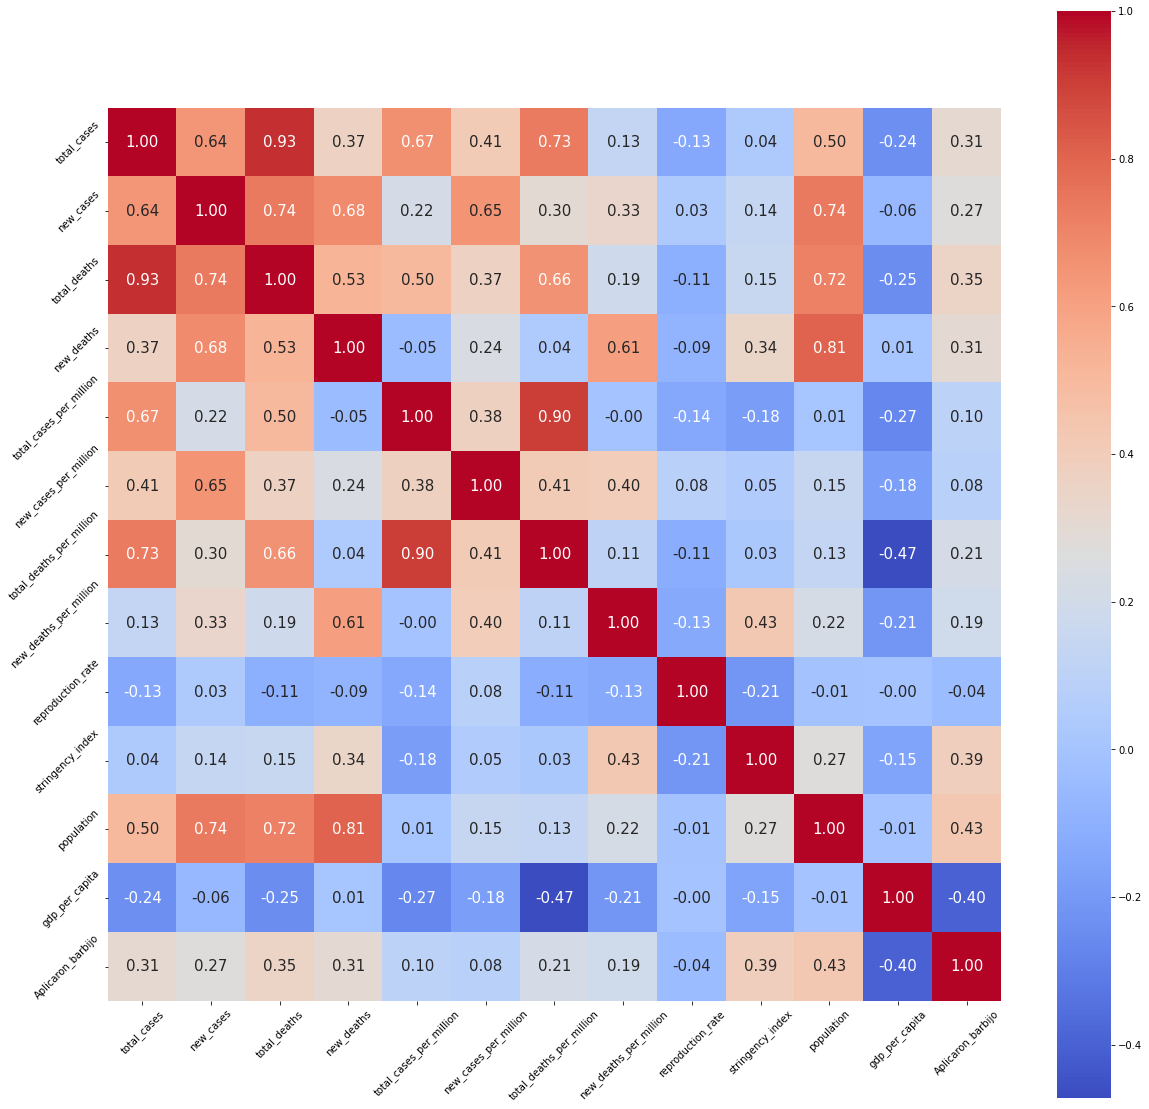

In [ ]:
#@title
corr = datos_covid_8paises_analisis_ml.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Usamos los indicadores de tasa de reproducción, muertes por millon y casos

In [ ]:
feature_cols = ["new_cases_per_million","new_deaths_per_million","reproduction_rate","stringency_index"]
X = datos_covid_8paises_analisis_ml[feature_cols] 
y = datos_covid_8paises_analisis_ml.Aplicaron_barbijo

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_pred=logreg.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Matriz:")
cnf_matrix

Matriz:


array([[387, 163],
       [162, 328]])

In [ ]:
print("Precisión:",accuracy_score(y_test, y_pred))

Precisión: 0.6875


###Hiperparámetros: Random Search

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [ ]:
parameter_grid = {'C':np.logspace(-2,1,100), 
                  'penalty':['l1', 'l2']  
                  }
 
random_search = RandomizedSearchCV(logreg, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [ ]:
result = random_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7080 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1590 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError:

In [ ]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6899648226014787
Best Hyperparameters: {'C': 3.849116286235326e-05, 'penalty': 'l2', 'solver': 'newton-cg'}


###Modelo final: Conclusión

In [ ]:
logreg = LogisticRegression(C= 3.849116286235326e-05, penalty= 'l2', solver= 'newton-cg')

logreg.fit(X_train,y_train)

LogisticRegression(C=3.849116286235326e-05, solver='newton-cg')

In [ ]:
y_predicted_ln_train = logreg.predict(X_train)
y_predicted_ln_test = logreg.predict(X_test)
metricas(y_predicted_ln_train,y_predicted_ln_test)

MSE de train: 0.30853110968569597
MSE de test: 0.30673076923076925
Diferencia: 0.0018003404549267188
 
RMSE de train: 0.5554557675330196
RMSE de test: 0.5538327989842866
Diferencia: 0.0016229685487330059
 
MAE de train: 0.30853110968569597
MAE de test: 0.30673076923076925
Diferencia: 0.0018003404549267188
 


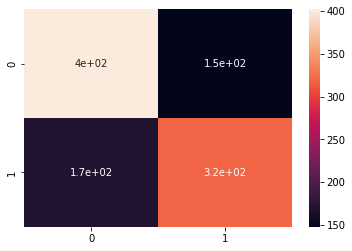

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predicted_ln_test)
sns.heatmap(cf_matrix, annot=True)

*Matriz de confusión de test*

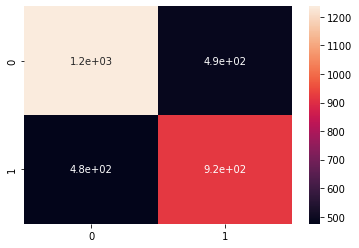

In [ ]:
cf_matrix = confusion_matrix(y_train, y_predicted_ln_train)
sns.heatmap(cf_matrix, annot=True)

*Matriz de confusión de train*

In [ ]:
accuracy_score(y_test, y_predicted_ln_test)

0.6932692307692307

In [ ]:
w0 = logreg.intercept_[0]
w = w1, w2, w3,w4= logreg.coef_[0]

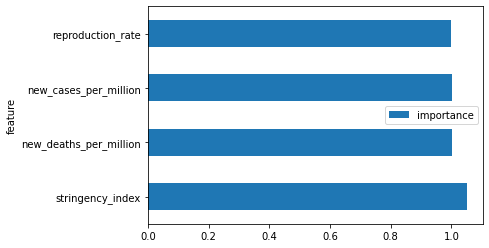

In [ ]:
feature_importance = pd.DataFrame(feature_cols, columns = ["feature"])
feature_importance["importance"] = pow(math.e,w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

*Gráfico de las features más importantes para el modelo*

In [ ]:
feature_importance = feature_importance.iloc[1: , :]

In [ ]:
feature_importance

,feature,importance
1,new_deaths_per_million,1.003188
0,new_cases_per_million,1.001101
2,reproduction_rate,1.000072


In [ ]:
arrayImportance = feature_importance["importance"].apply(lambda x: pow(x, 100))

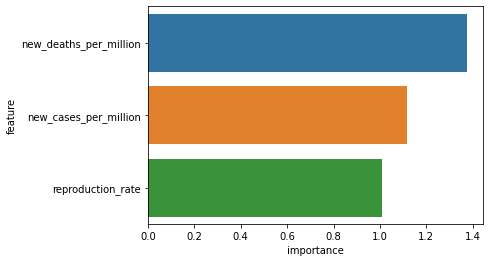

In [ ]:
sns.barplot(x =arrayImportance,y = "feature",data = feature_importance)

*Gráfico de los indicadores importantes para el modelo, reescalado para ver mejor las diferencias.*

Para este proyecto se eligieron a Estados Unidos, Reino Unido, Canadá y Francia como ejemplos de países que aplicaron barbijo obligatorio en el transcurso de Abril y Mayo de 2020, mientras que Suecia, Finlandia, Noruega y España no. Ambos grupos tuvieron buen desempeño por igual, esto puede deberse a los factores aclarados previamente y los culturales.

El clasificador realizado aprendió en conjunto a otra política que es la severidad de la cuarentena, ya que es otro factor importante que todos los países aplicaron simultáneamente. Teniendo en cuenta esto, el modelo nos permite saber qué es lo que más va a afectar el uso o no de barbijo obligatorio, en este caso las muertes por millón nos ayudan mejor a predecir si serviría o no ésta política. Aunque todos estos indicadores o el mismo clasificador, no serían válidos analizando si aplicaron o no esta política, si fuera el caso de un clasificador que tomaría en cuenta sólamente la severidad de las restricciones, podría predecir mejor el aumento o disminución de la propagación del virus.
